In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from os.path import join, dirname, abspath
import scipy.stats as stats
import seaborn as sns
from sklearn.preprocessing import StandardScaler, scale, MinMaxScaler

In [168]:
SPECIES = ['PJ', 'BV', 'AC', 'DP', 'BT', 'DL', 'BH', 'BP',
       'CS', 'EL']
FOLDER = join('Data', 'Species')
def load_growth_data(filename):
    """Load growth data from a CSV file."""
    data = pd.read_csv(join(FOLDER, filename))
    
    data_growth = (data[data['Time'] == 24][SPECIES].values - data[data['Time'] == 0][SPECIES].values )
    
    growth_df = pd.DataFrame(data_growth, columns=SPECIES)
    growth_df['Treatments'] = data[data['Time'] == 24]['Treatments'].values
    growth_df = growth_df.reset_index(drop=True)
    return growth_df

load_growth_data('PJ_growth_profile.csv')

,PJ,BV,AC,DP,BT,DL,BH,BP,CS,EL,Treatments
0,0.003724,0.196078,0.183944,0.448211,0.062132,0.696451,0.055866,0.046191,0.005828,0.065757,Inulin
1,0.002106,0.065855,0.199391,0.474670,0.045631,0.770538,0.063348,0.083587,0.004895,0.109176,Inulin
2,0.001673,0.076443,0.247271,0.398965,0.076639,0.802188,0.012637,0.042206,0.004290,0.079048,Inulin
3,0.001256,0.101921,0.208160,0.413006,0.106440,0.640984,0.019463,0.038375,0.004913,0.117527,Inulin
4,0.000191,0.492097,0.139730,0.361517,0.026856,0.718147,0.063573,0.002107,0.006184,0.115641,Inulin
...,...,...,...,...,...,...,...,...,...,...,...
132,0.018292,0.184676,-0.000843,0.000000,0.151108,0.048938,0.000000,0.000000,0.013497,0.000000,Xylan
133,0.019750,0.117305,0.002189,0.321105,0.143482,0.028290,0.011973,0.004702,0.002045,0.000000,Xylan
134,0.065944,0.000000,-0.000310,0.477206,0.000000,0.000000,0.015235,0.051420,0.006205,0.105500,Xylan
135,0.057380,0.000000,0.000000,0.384680,0.000000,0.082534,0.024513,0.048725,0.004495,0.187006,Xylan


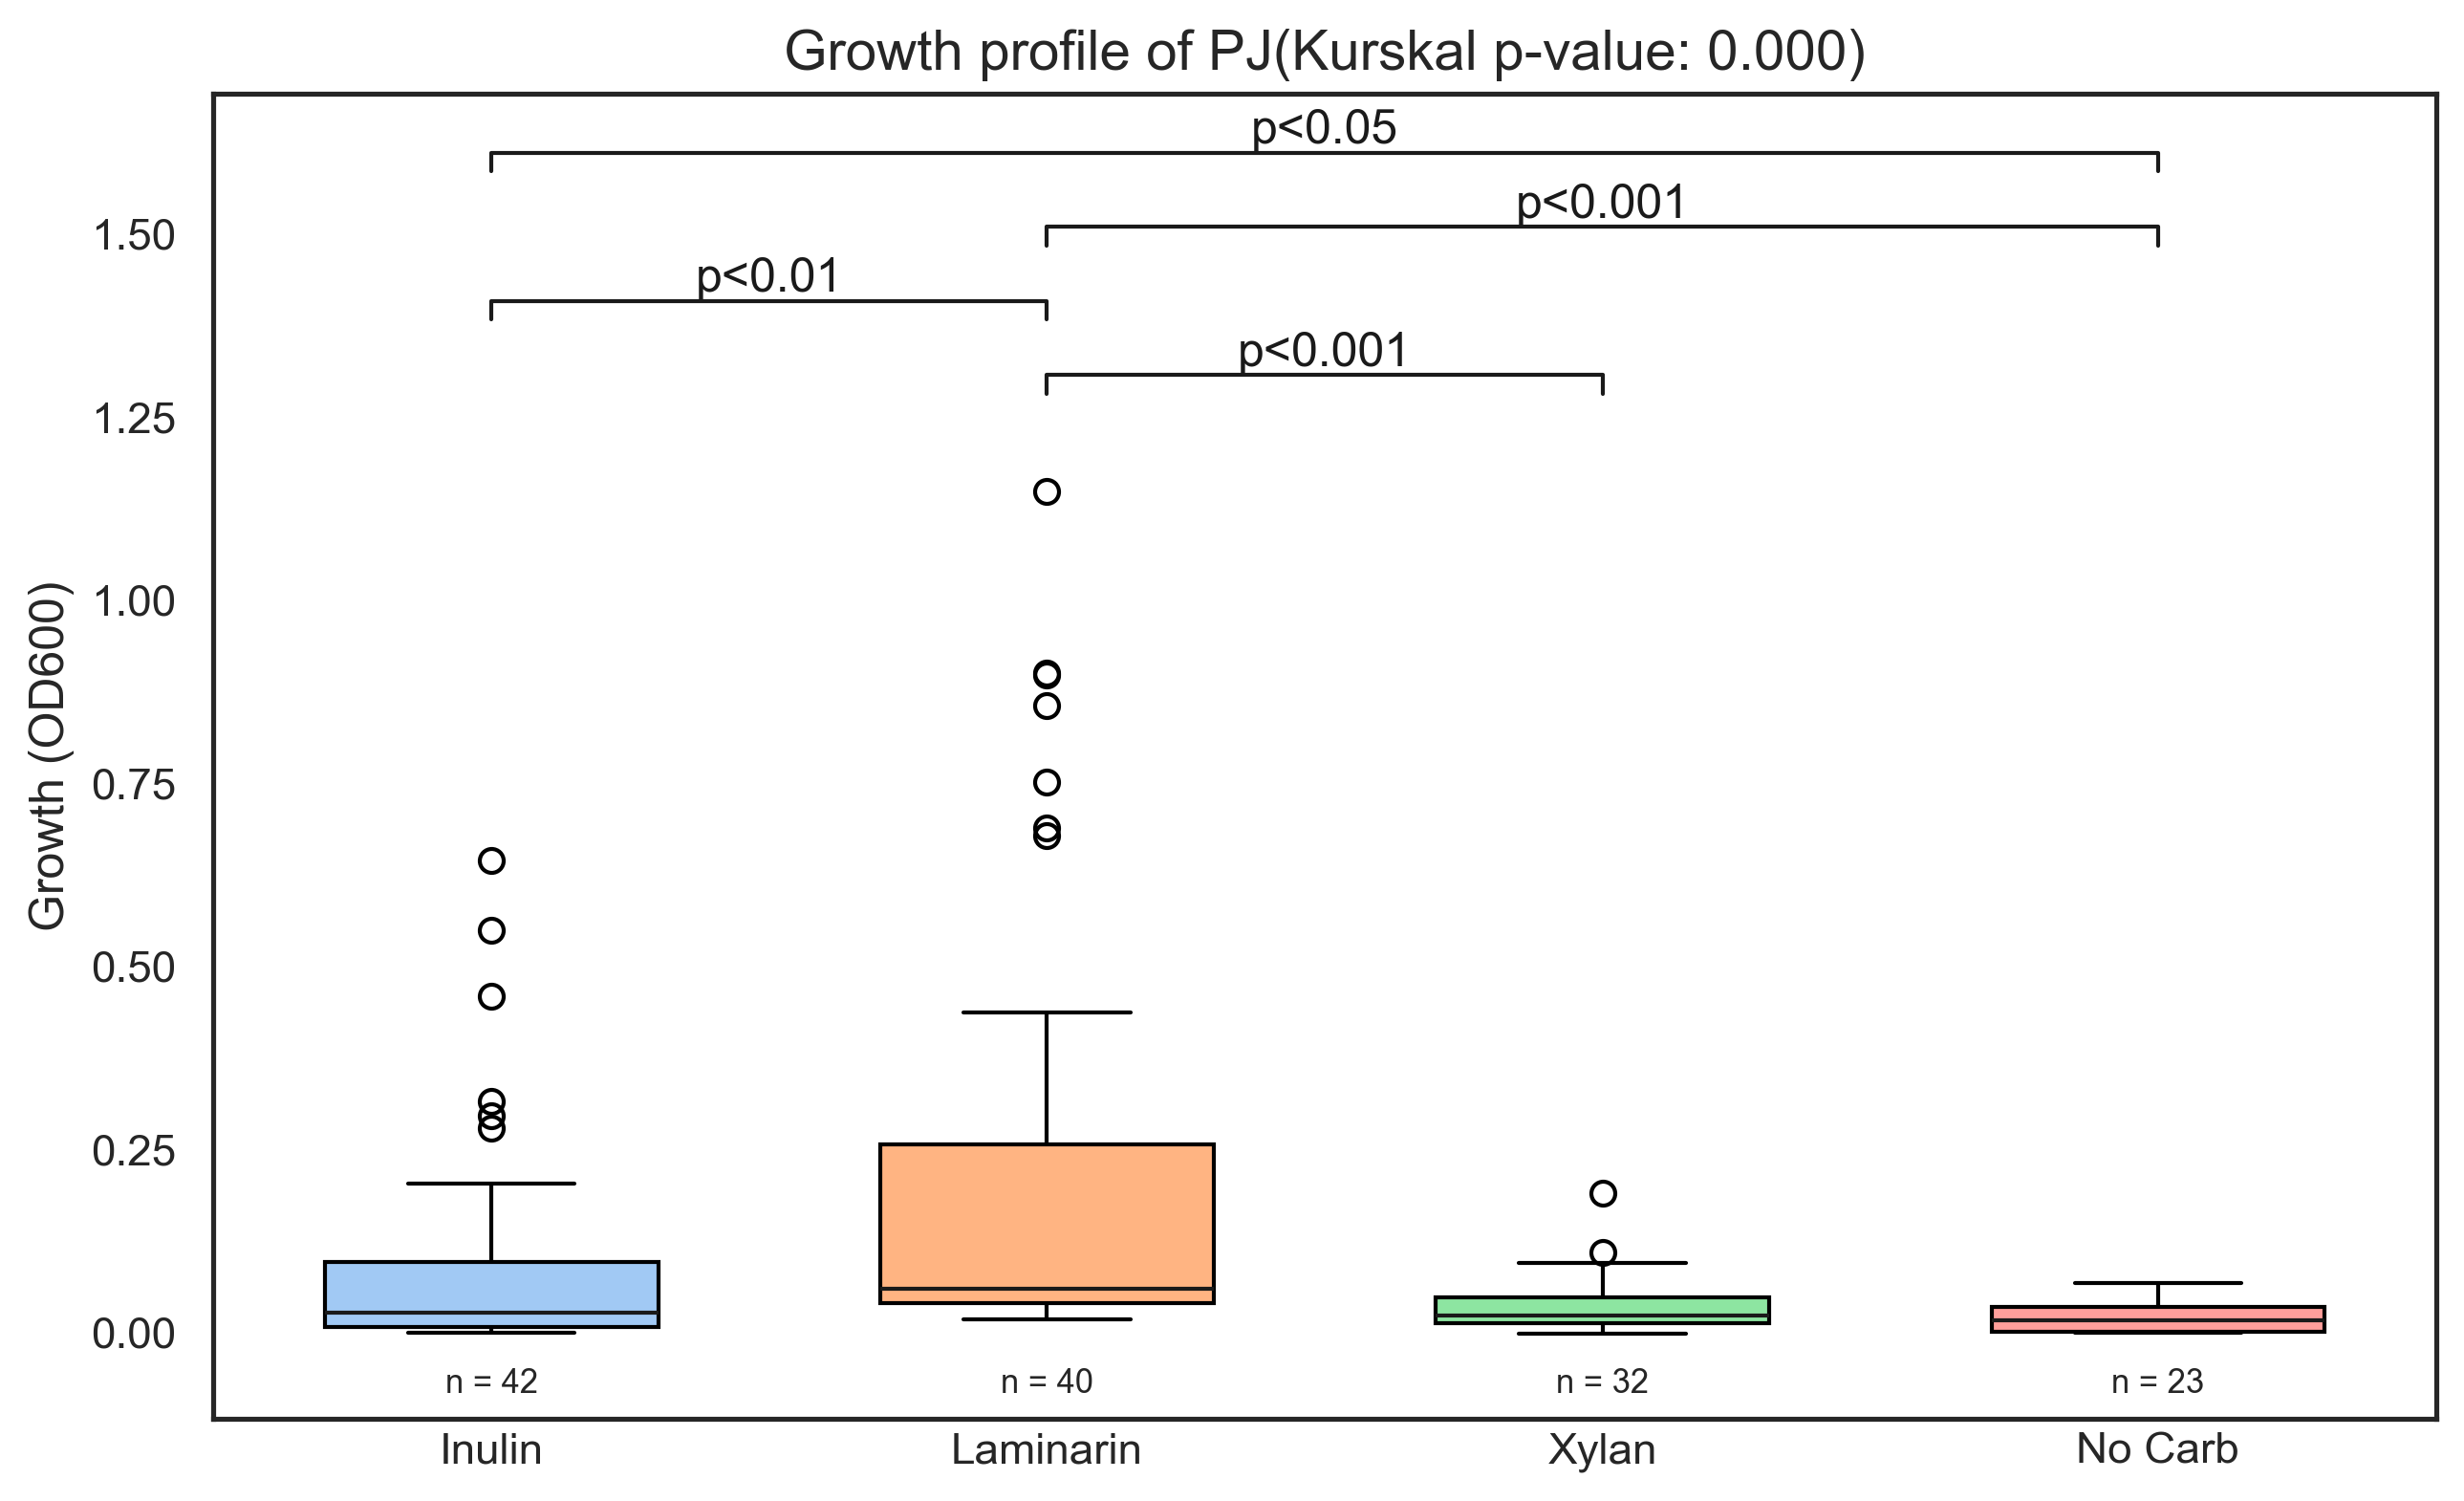

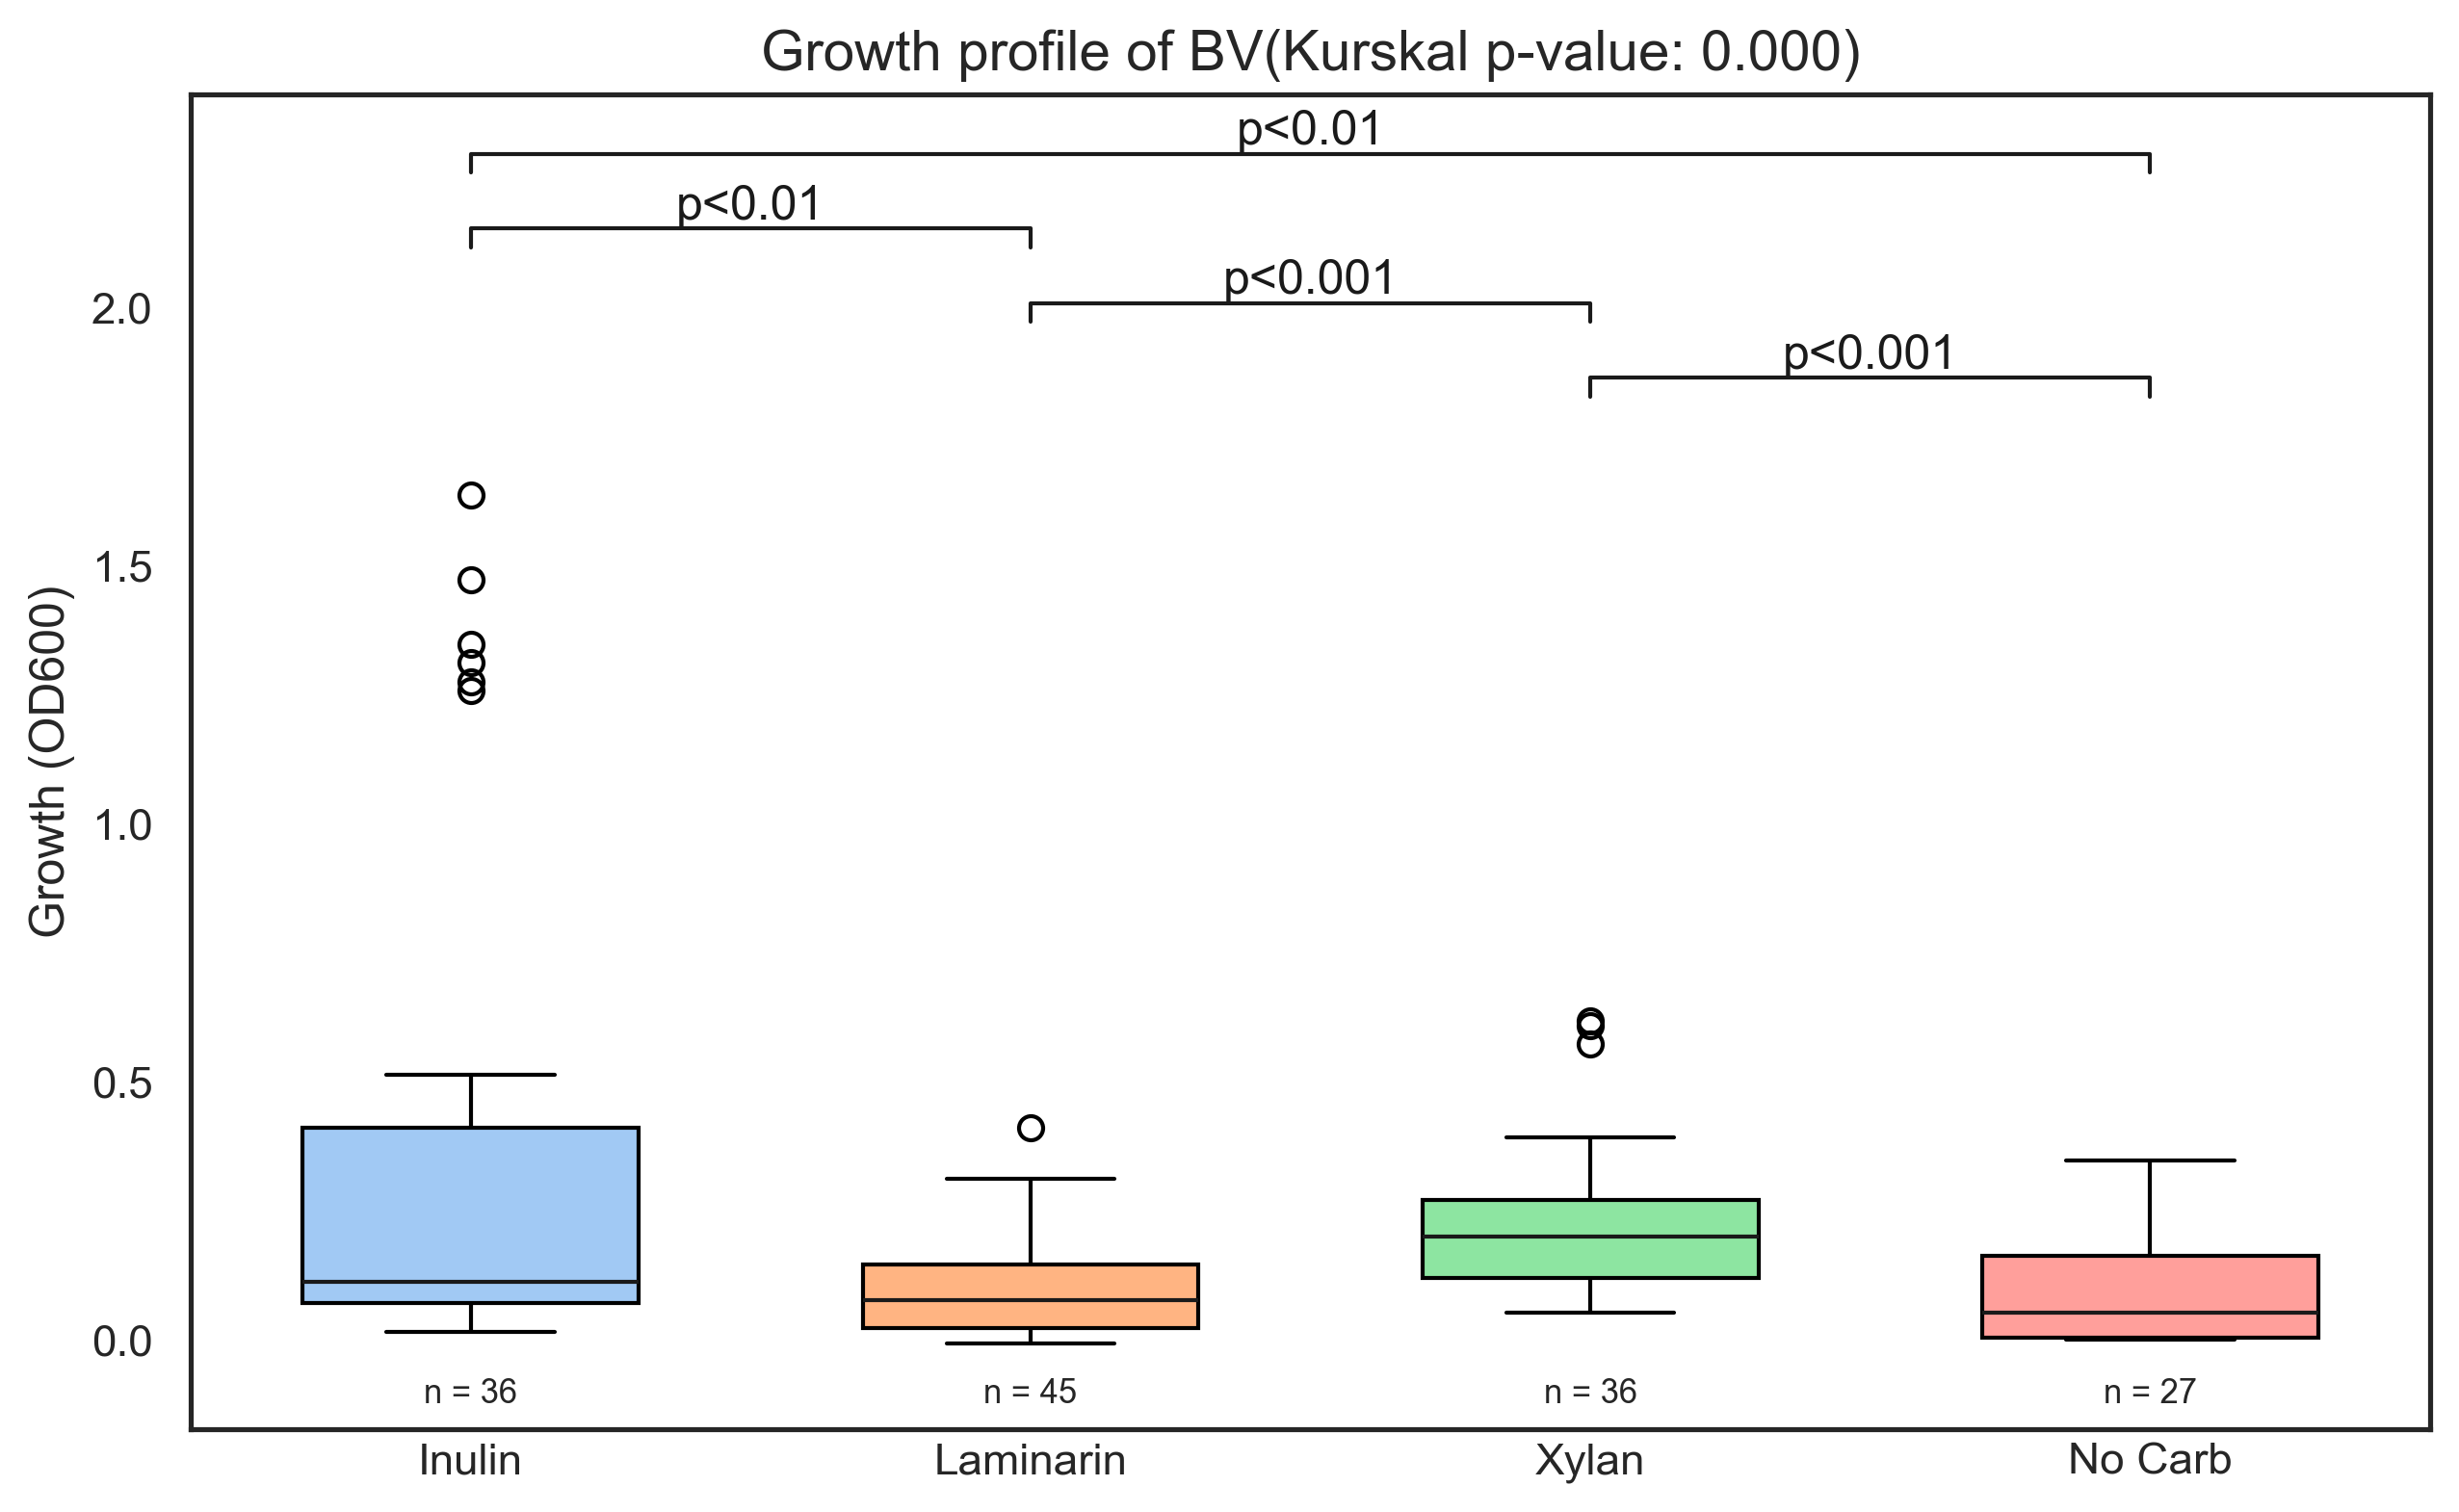

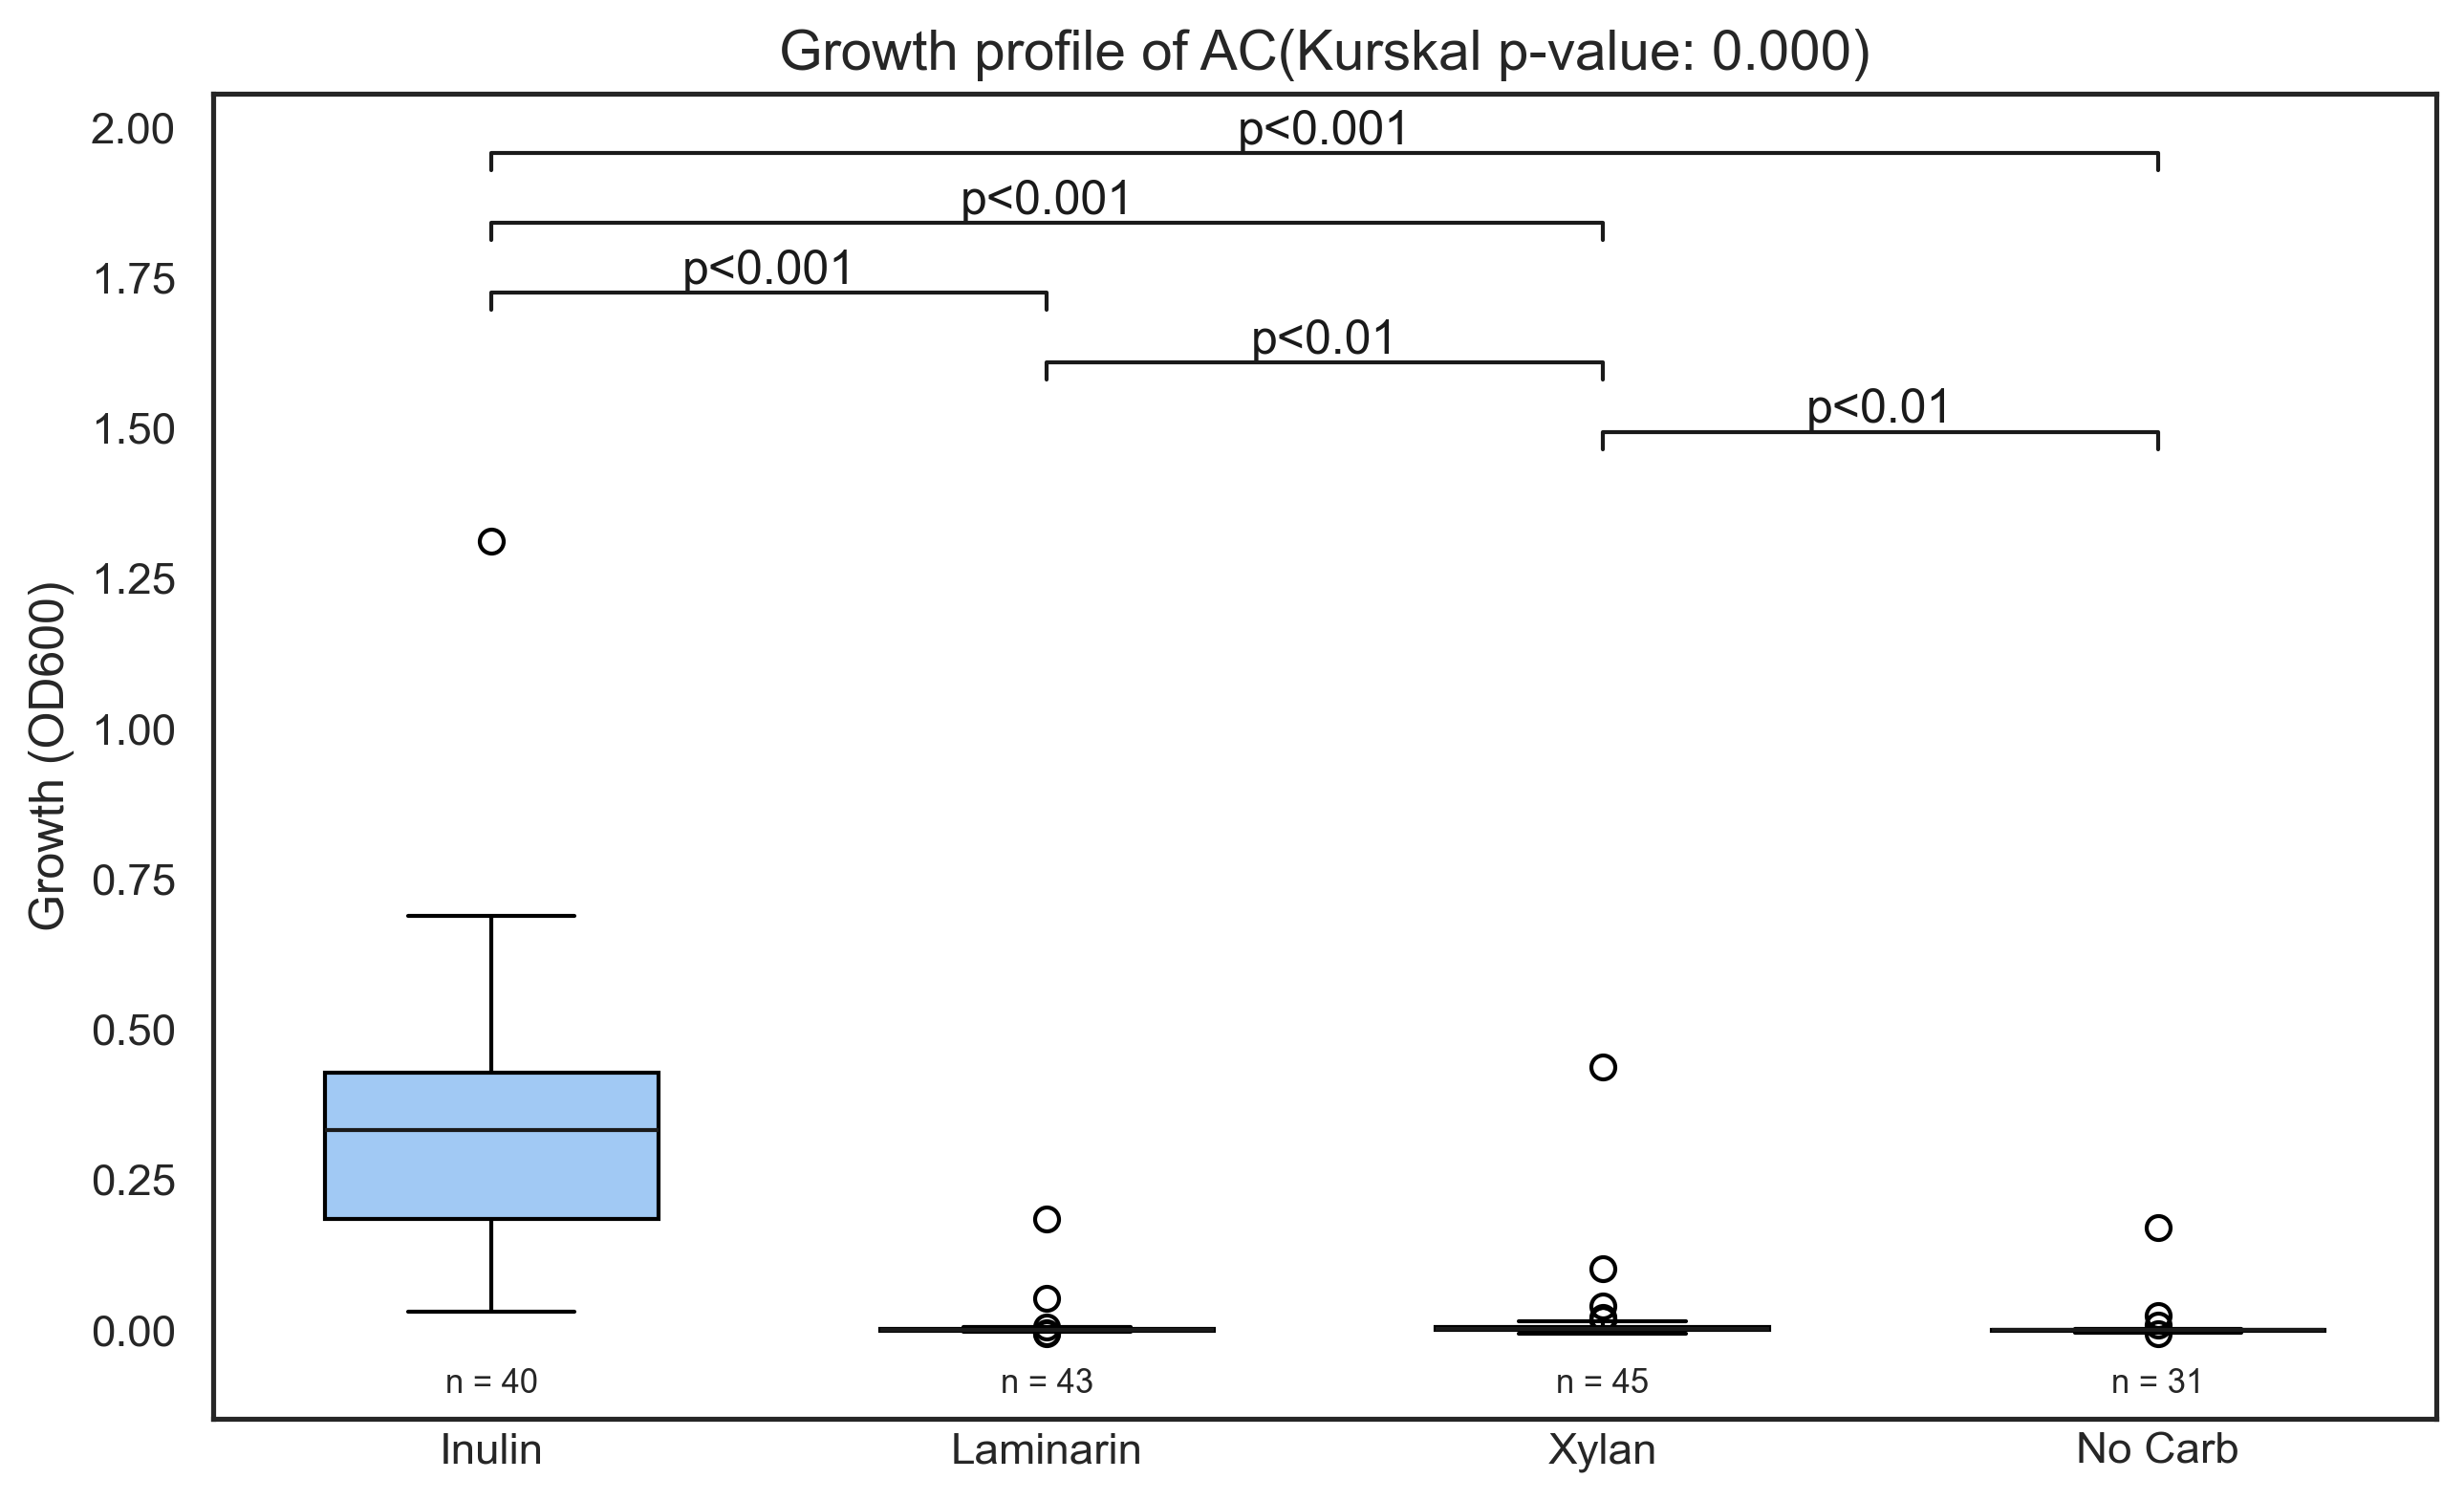

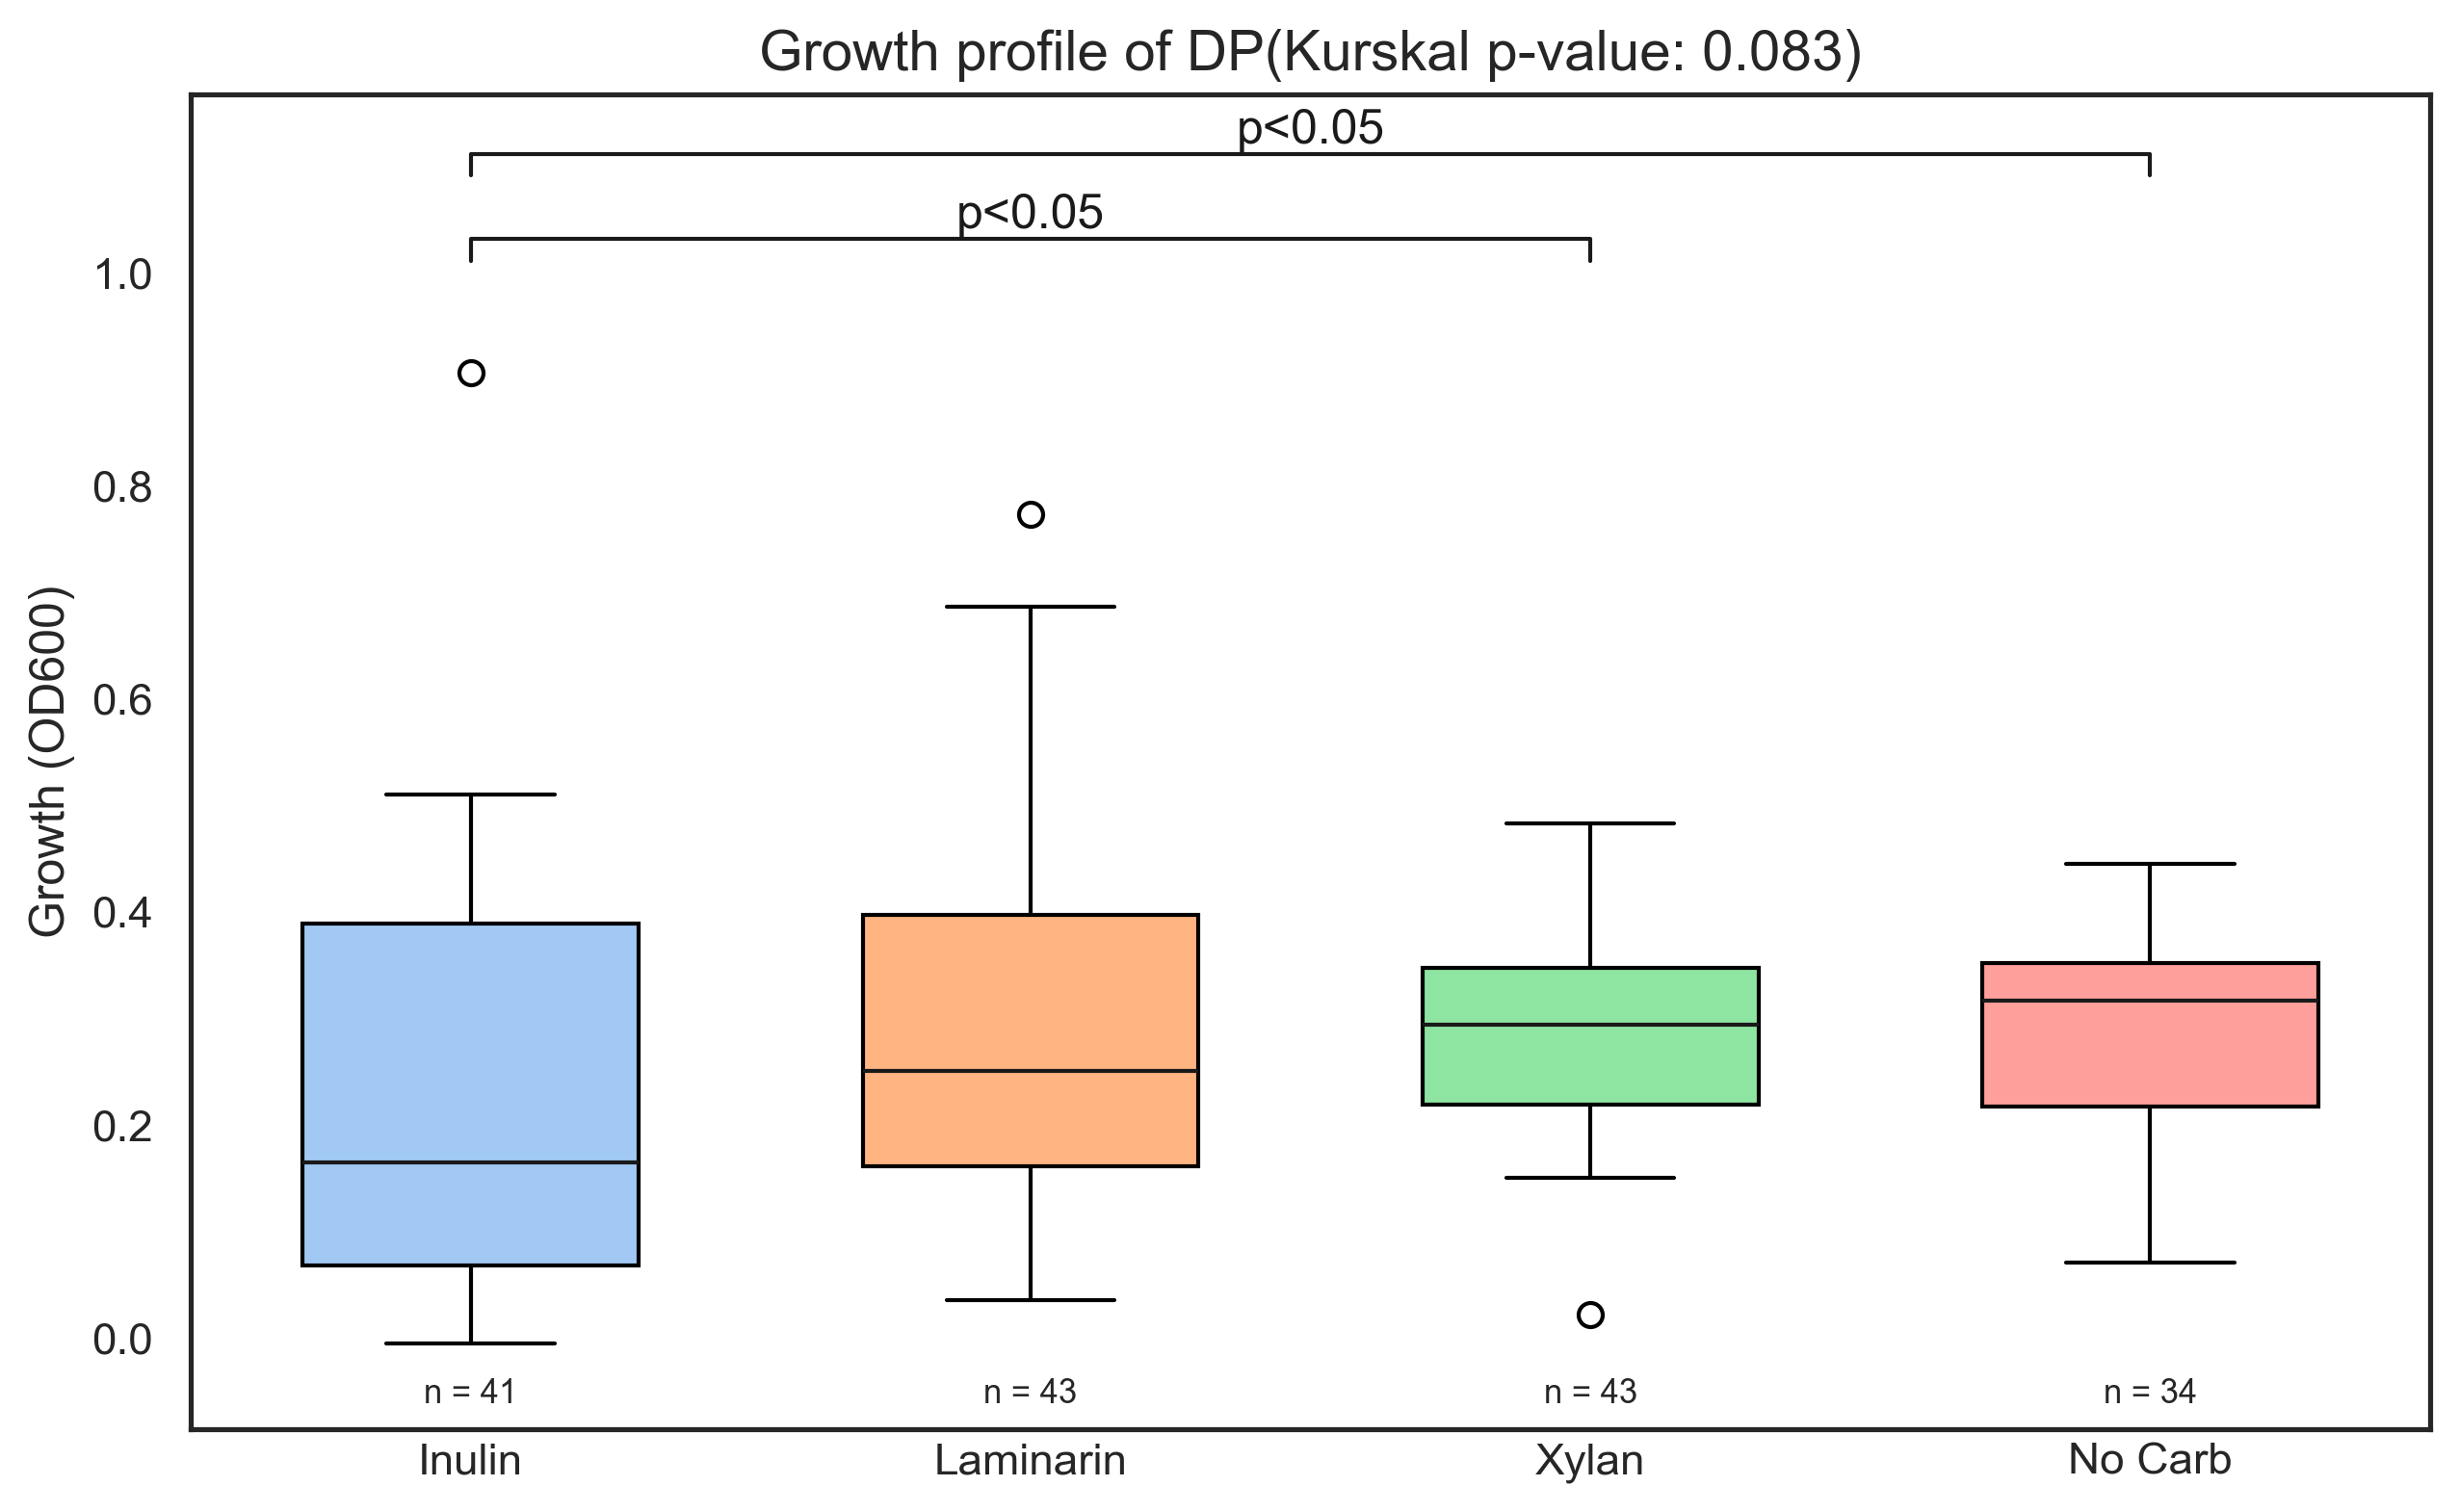

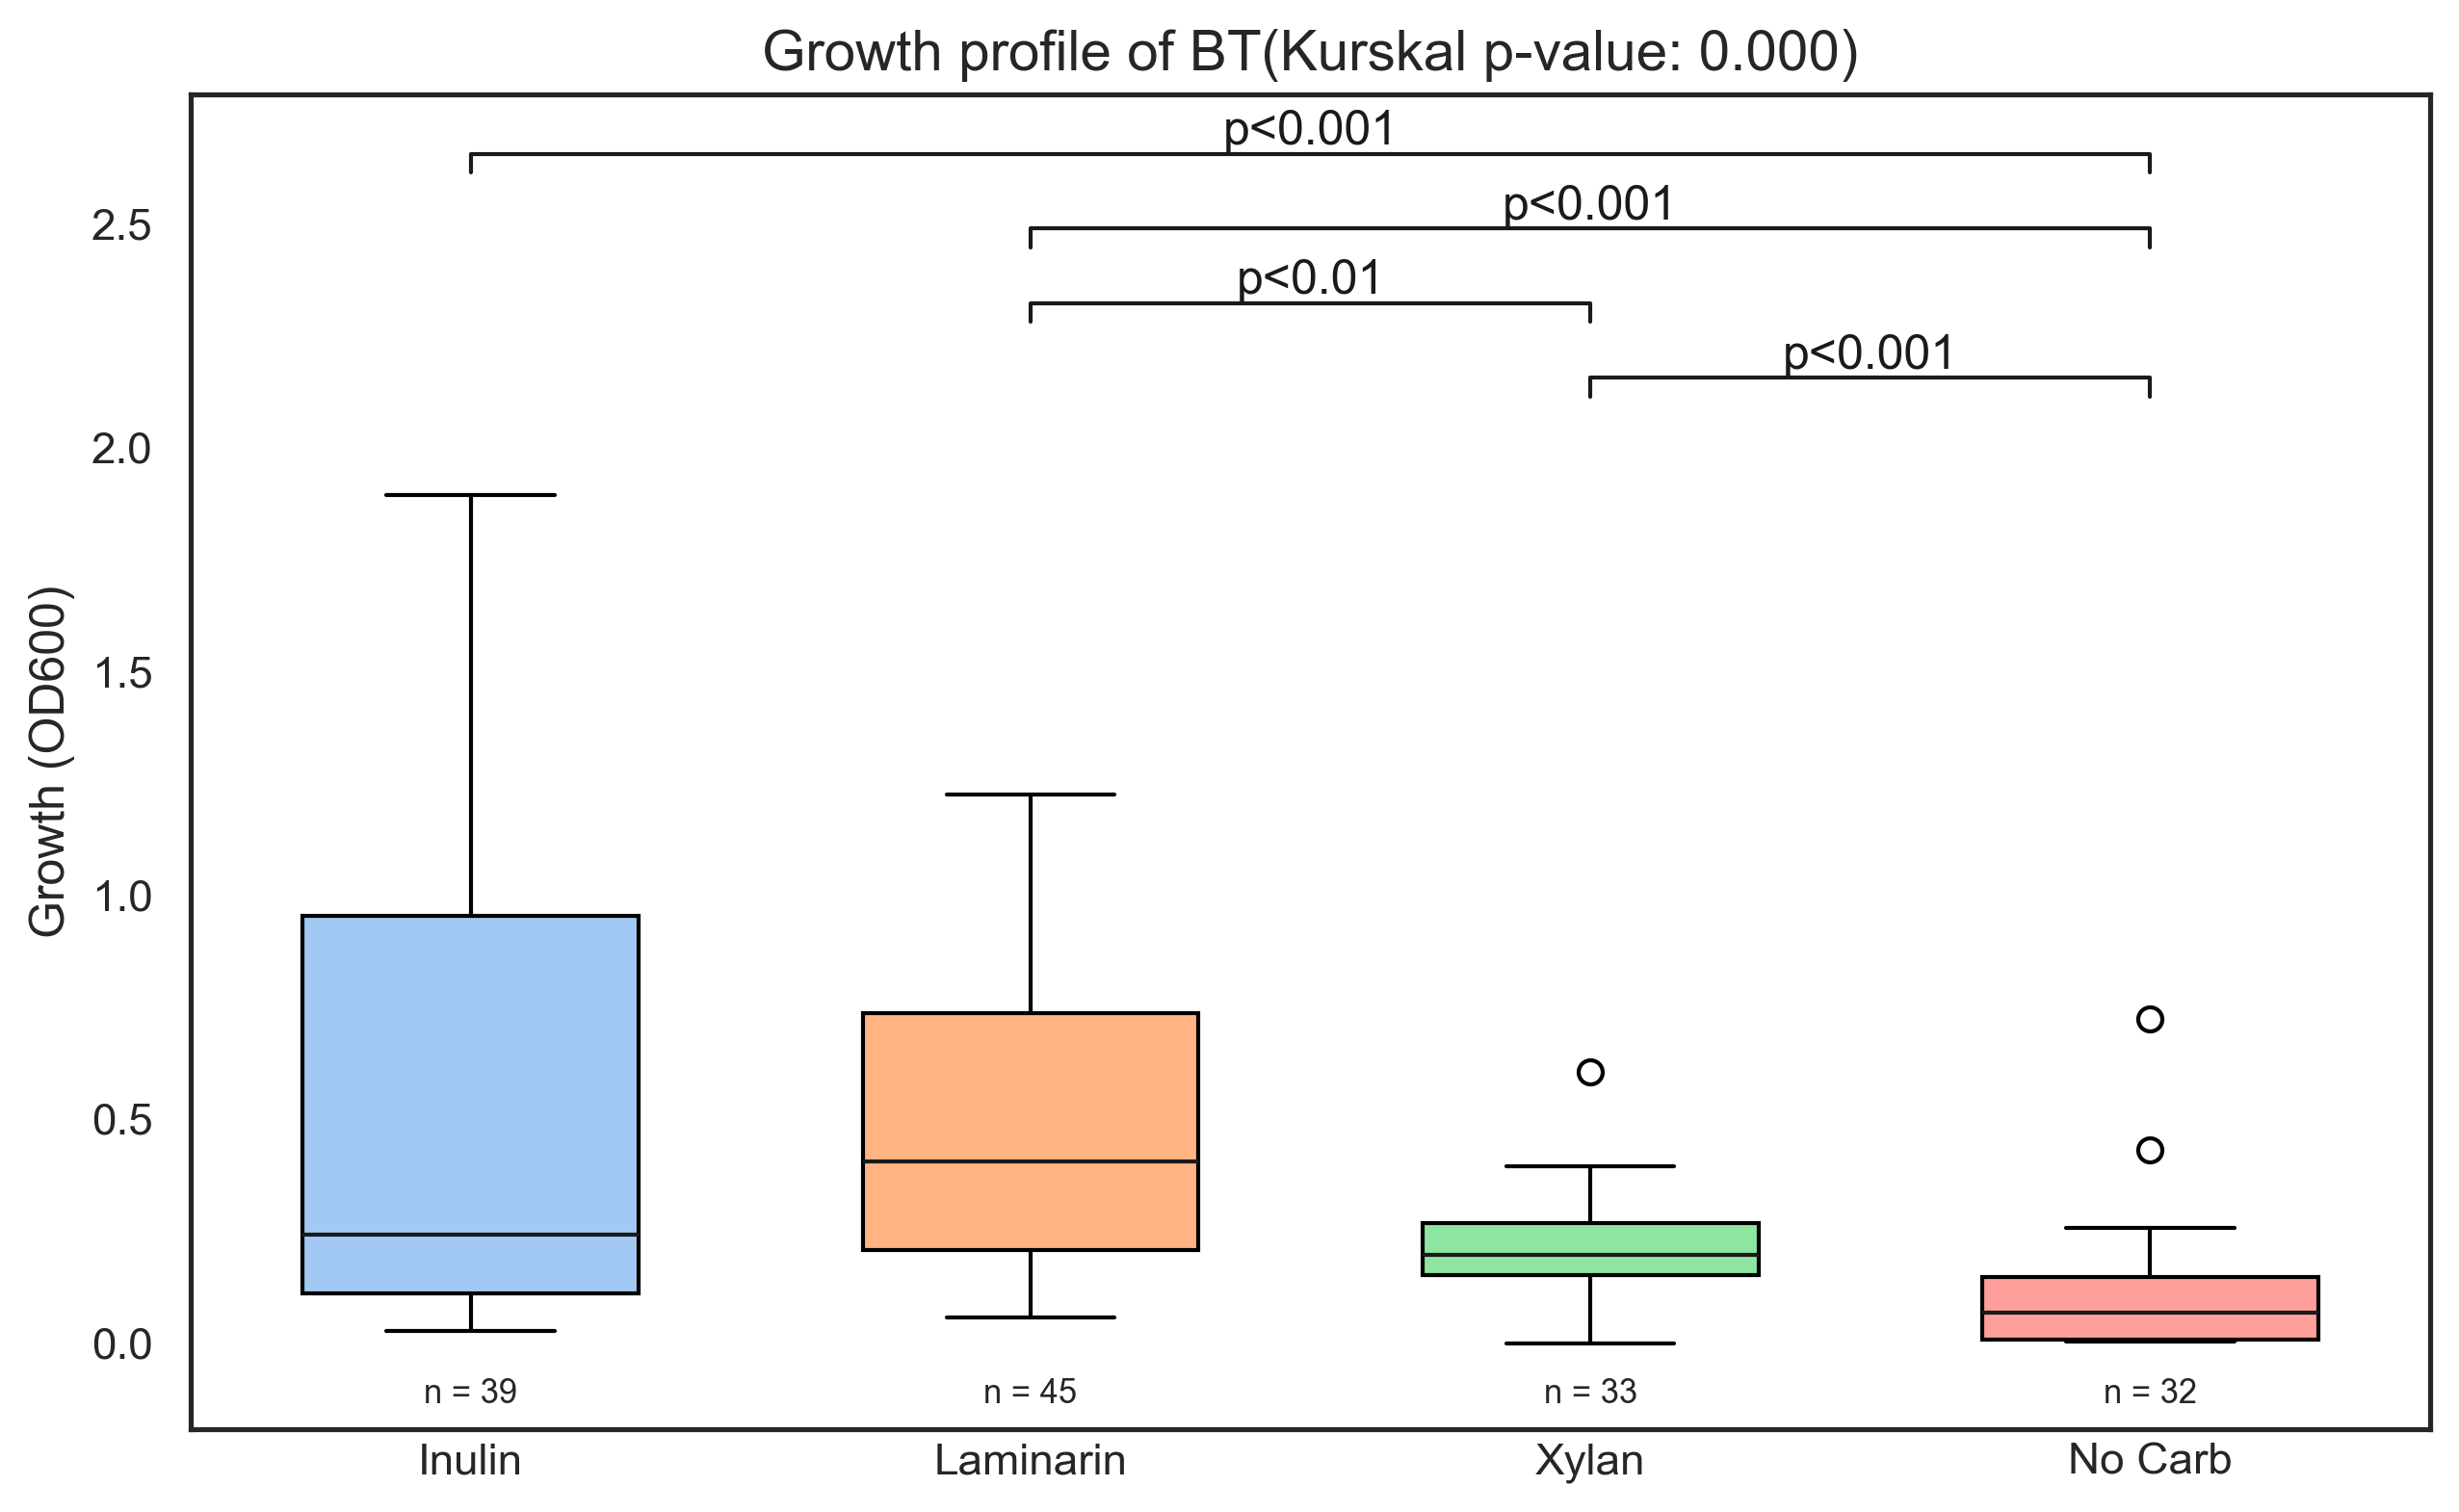

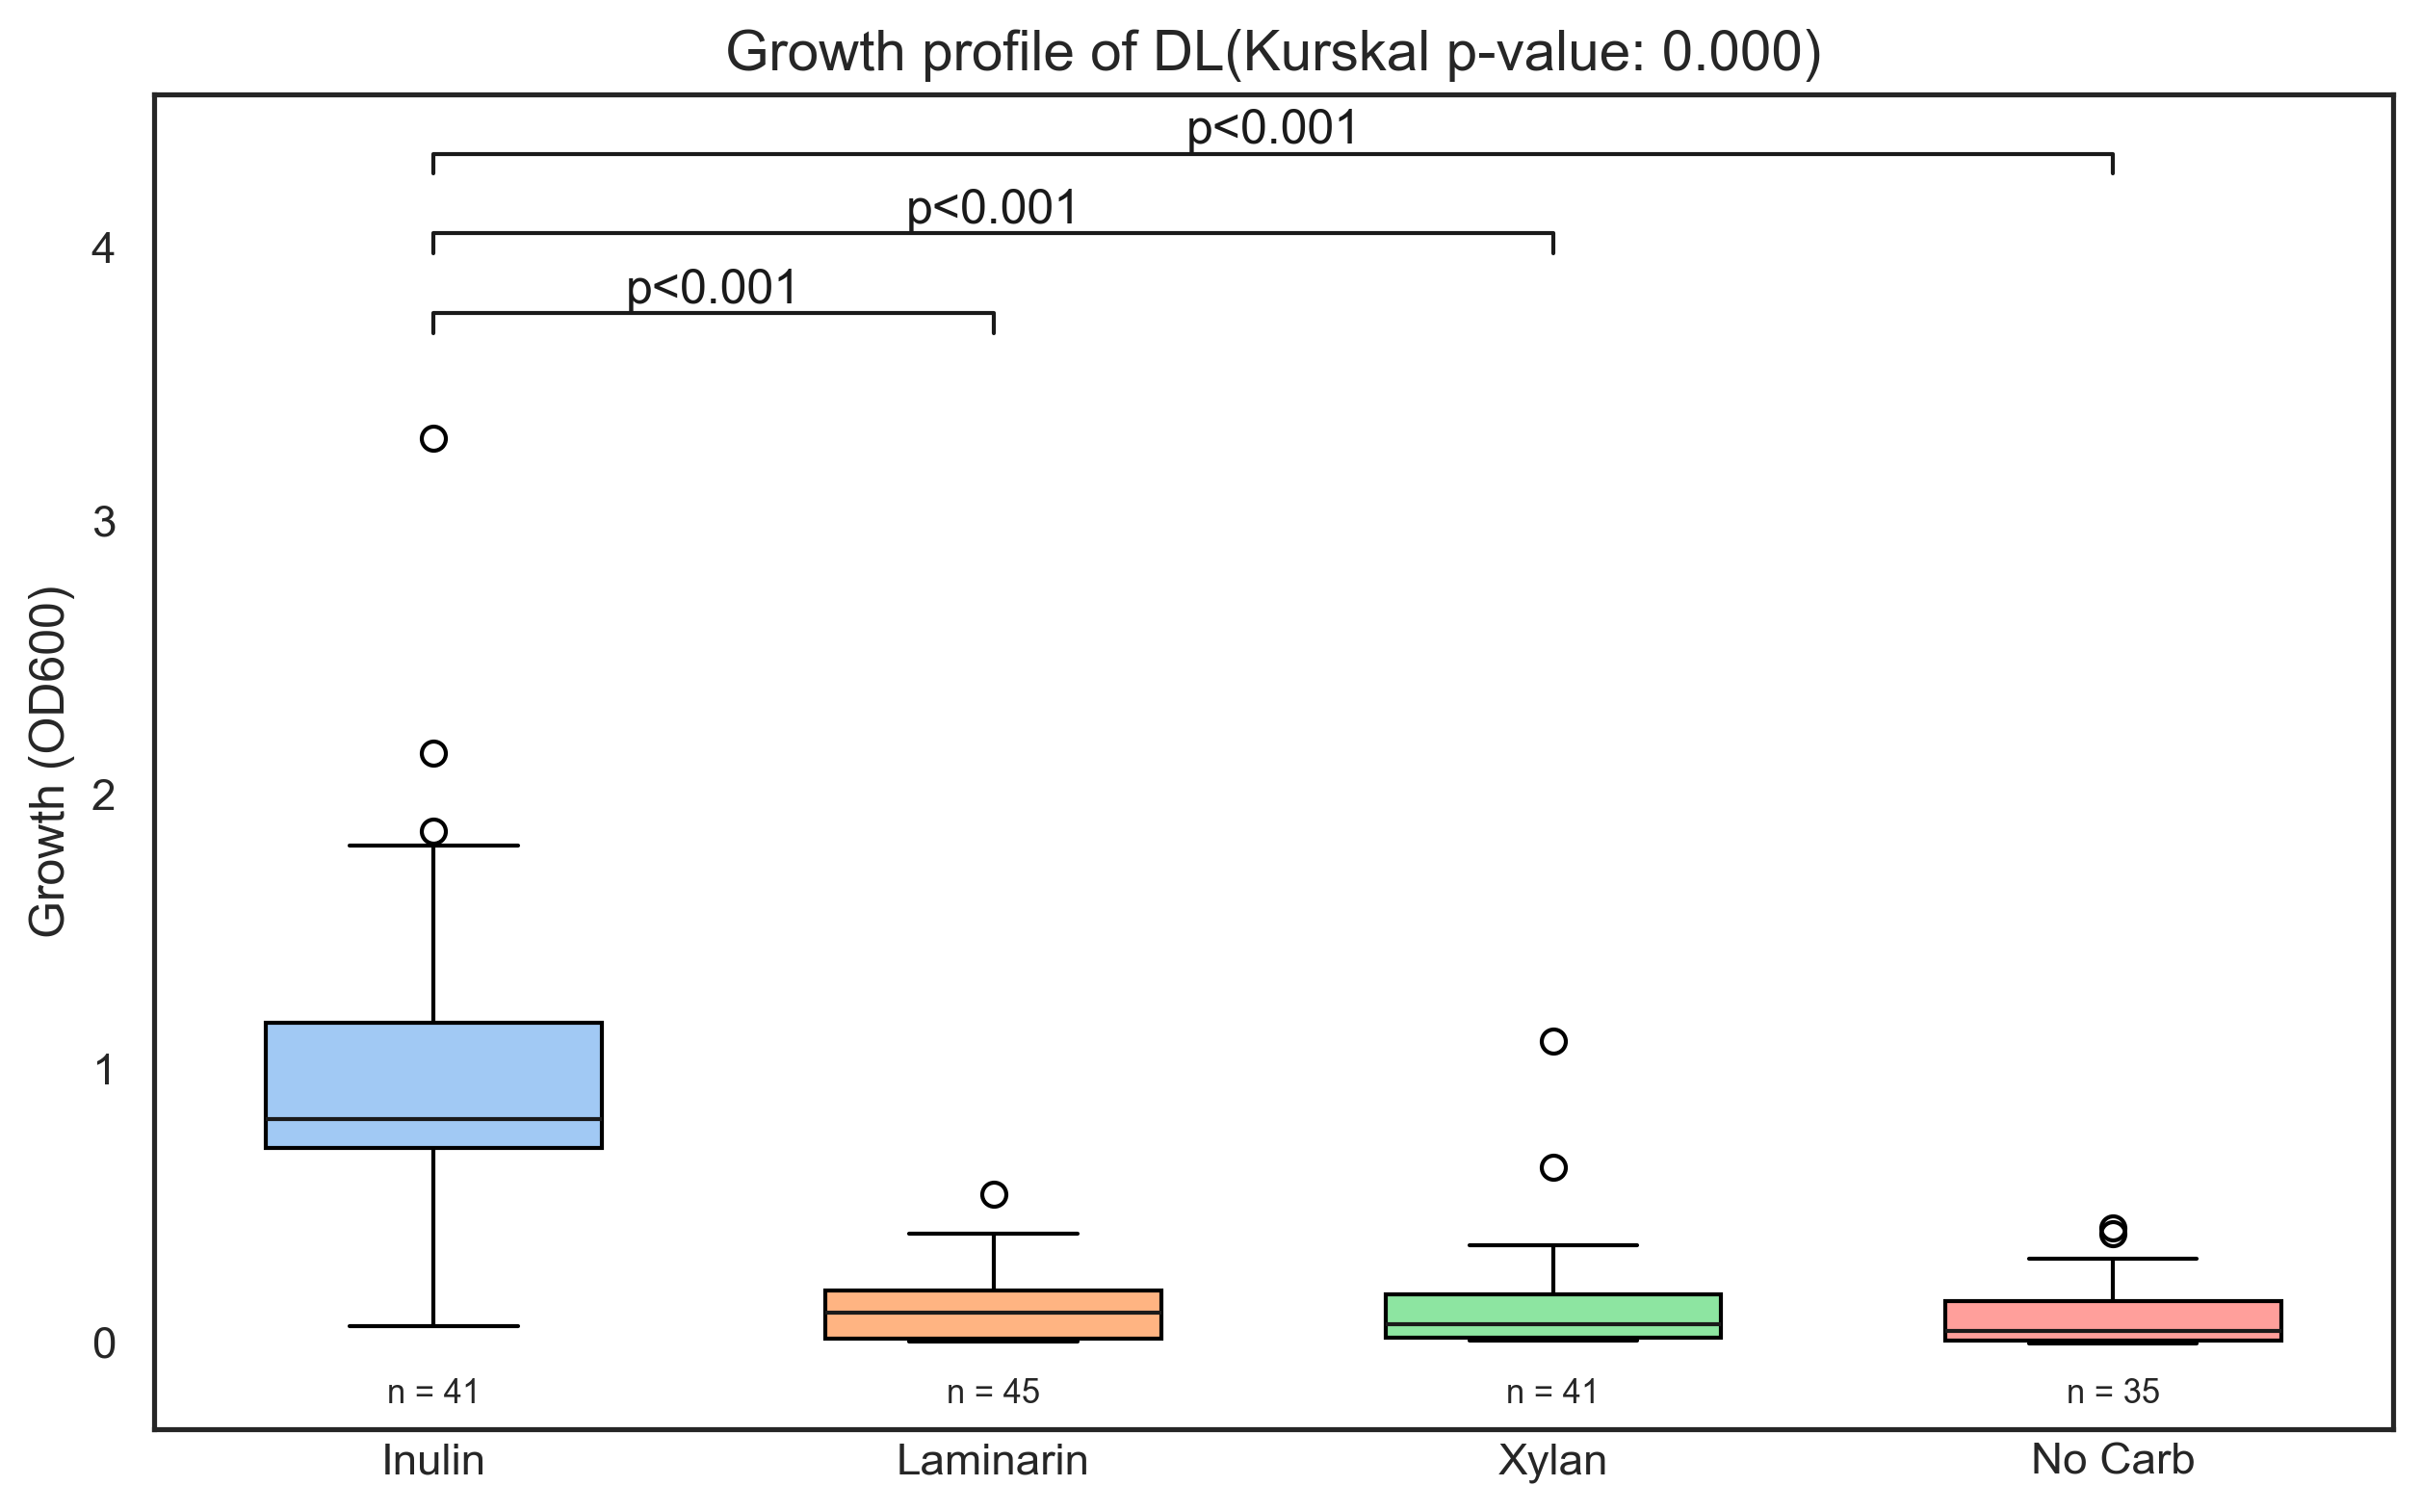

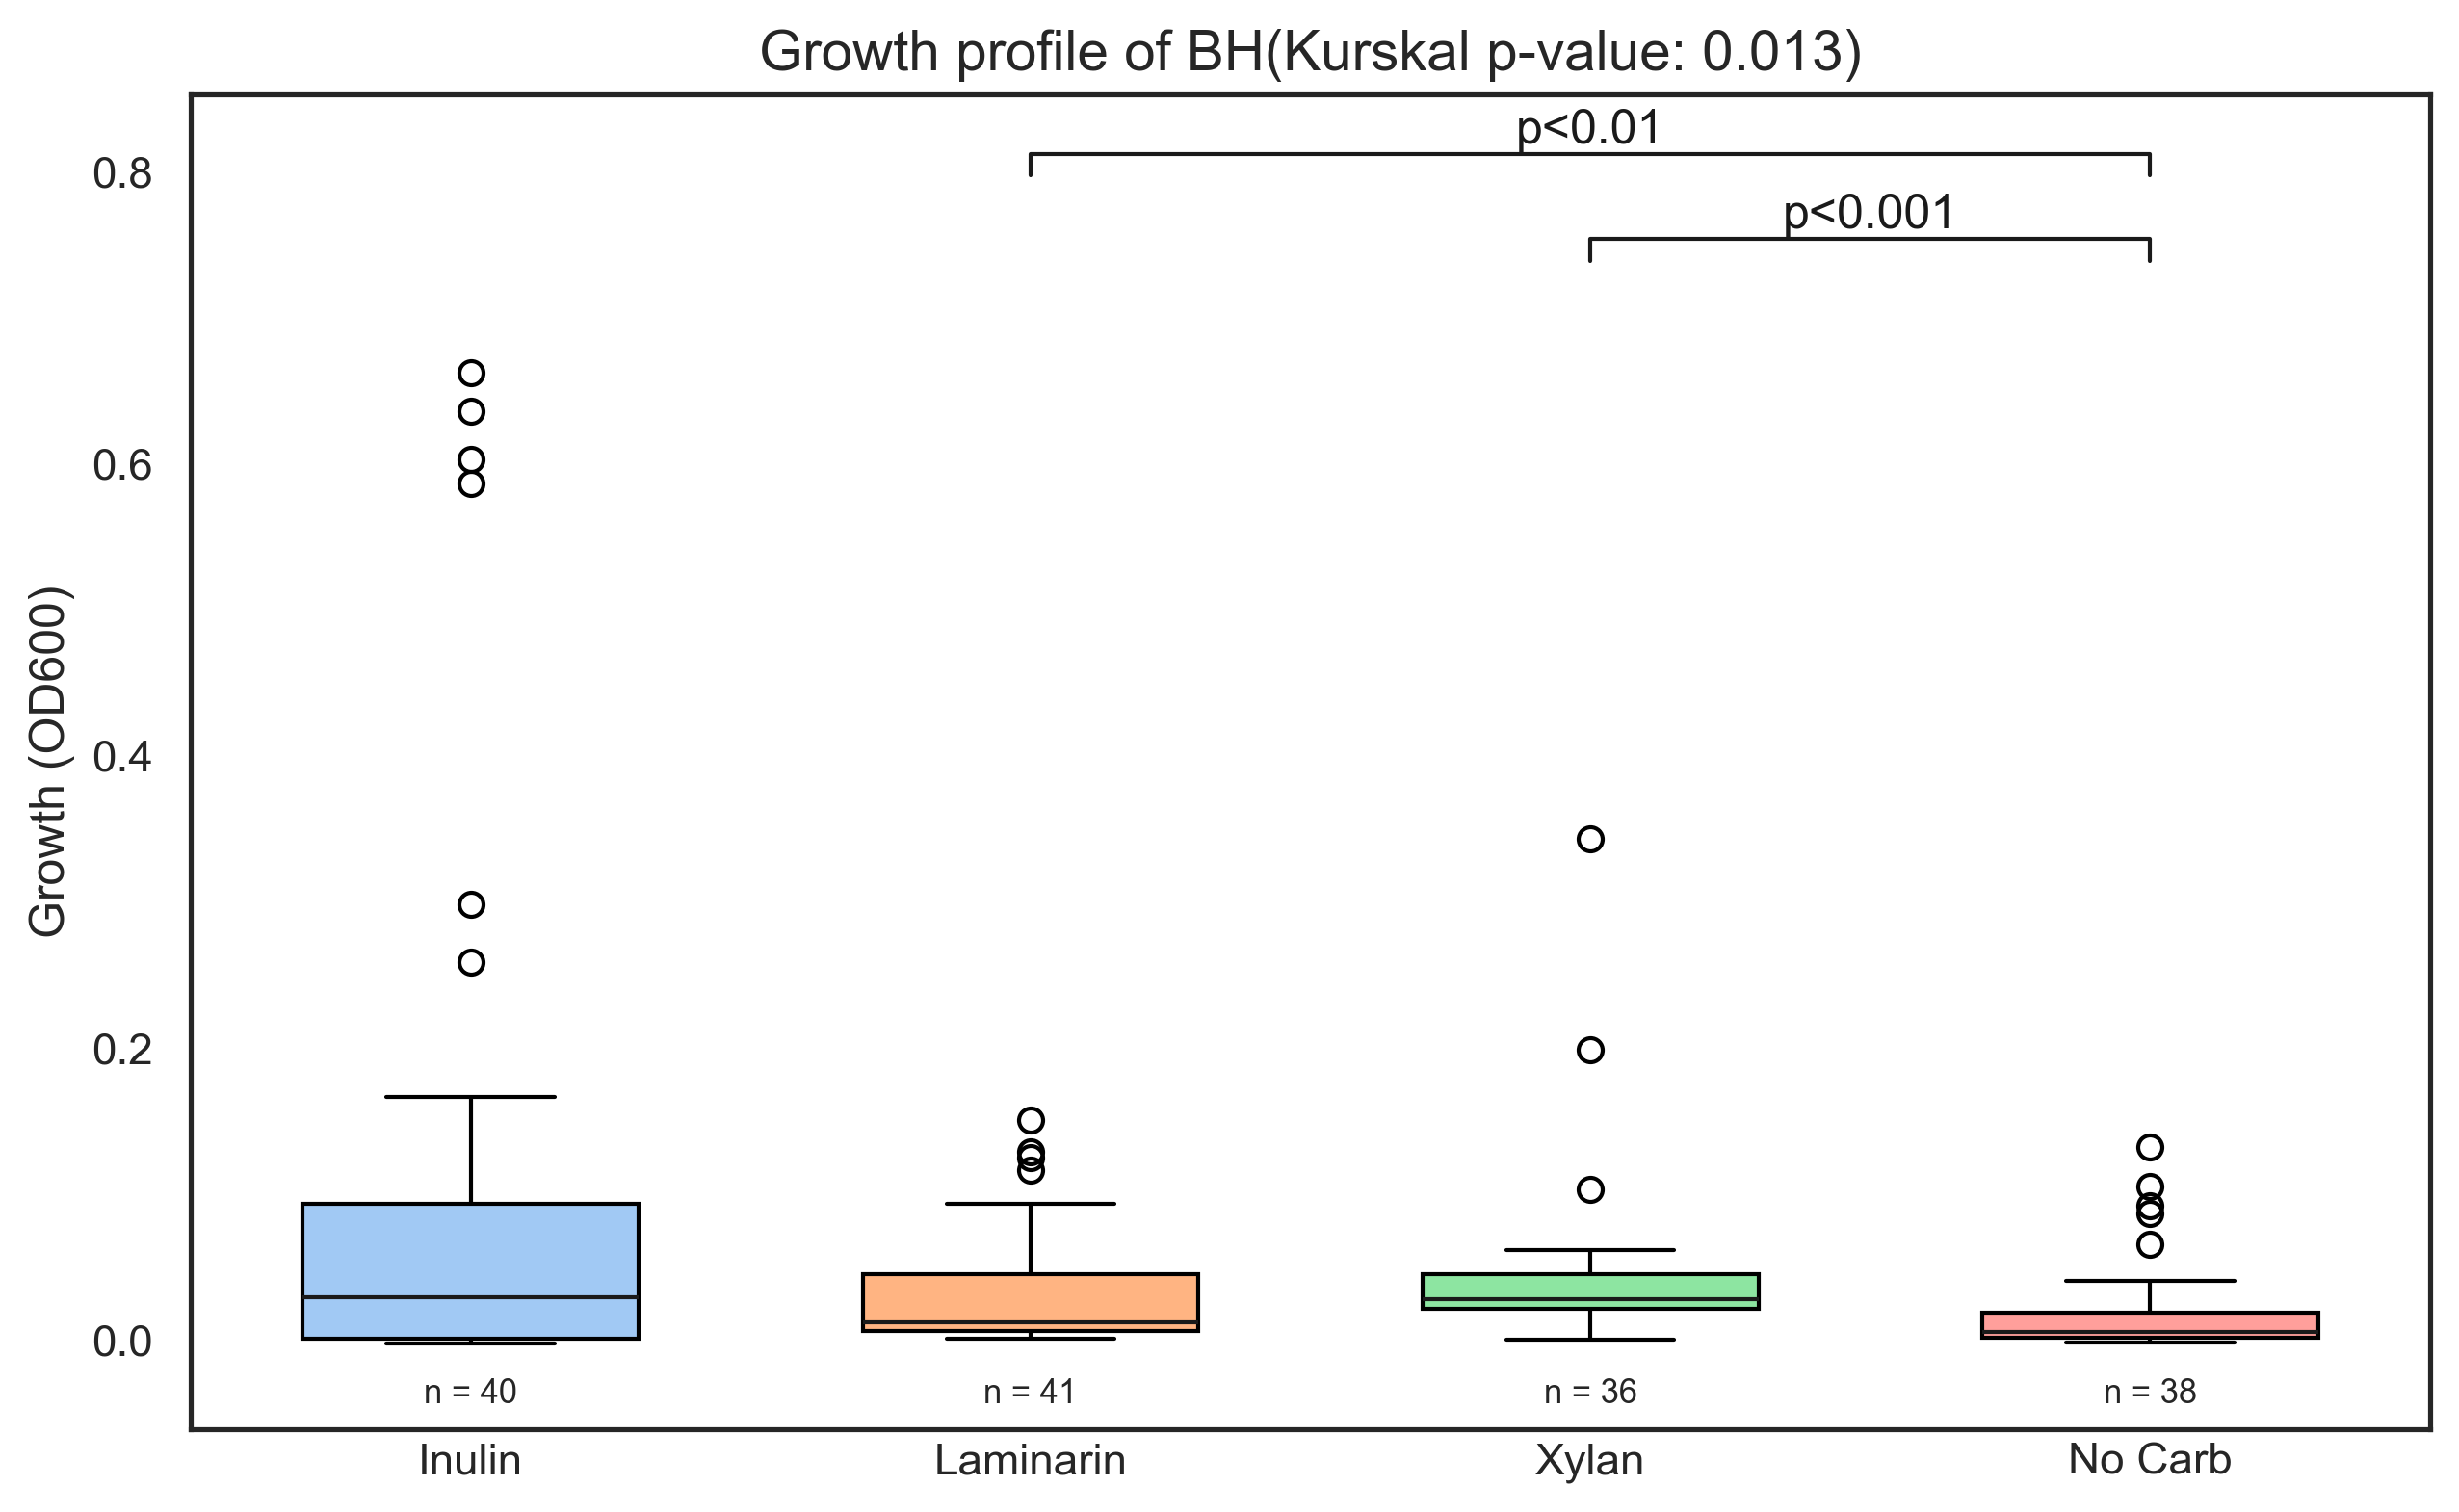

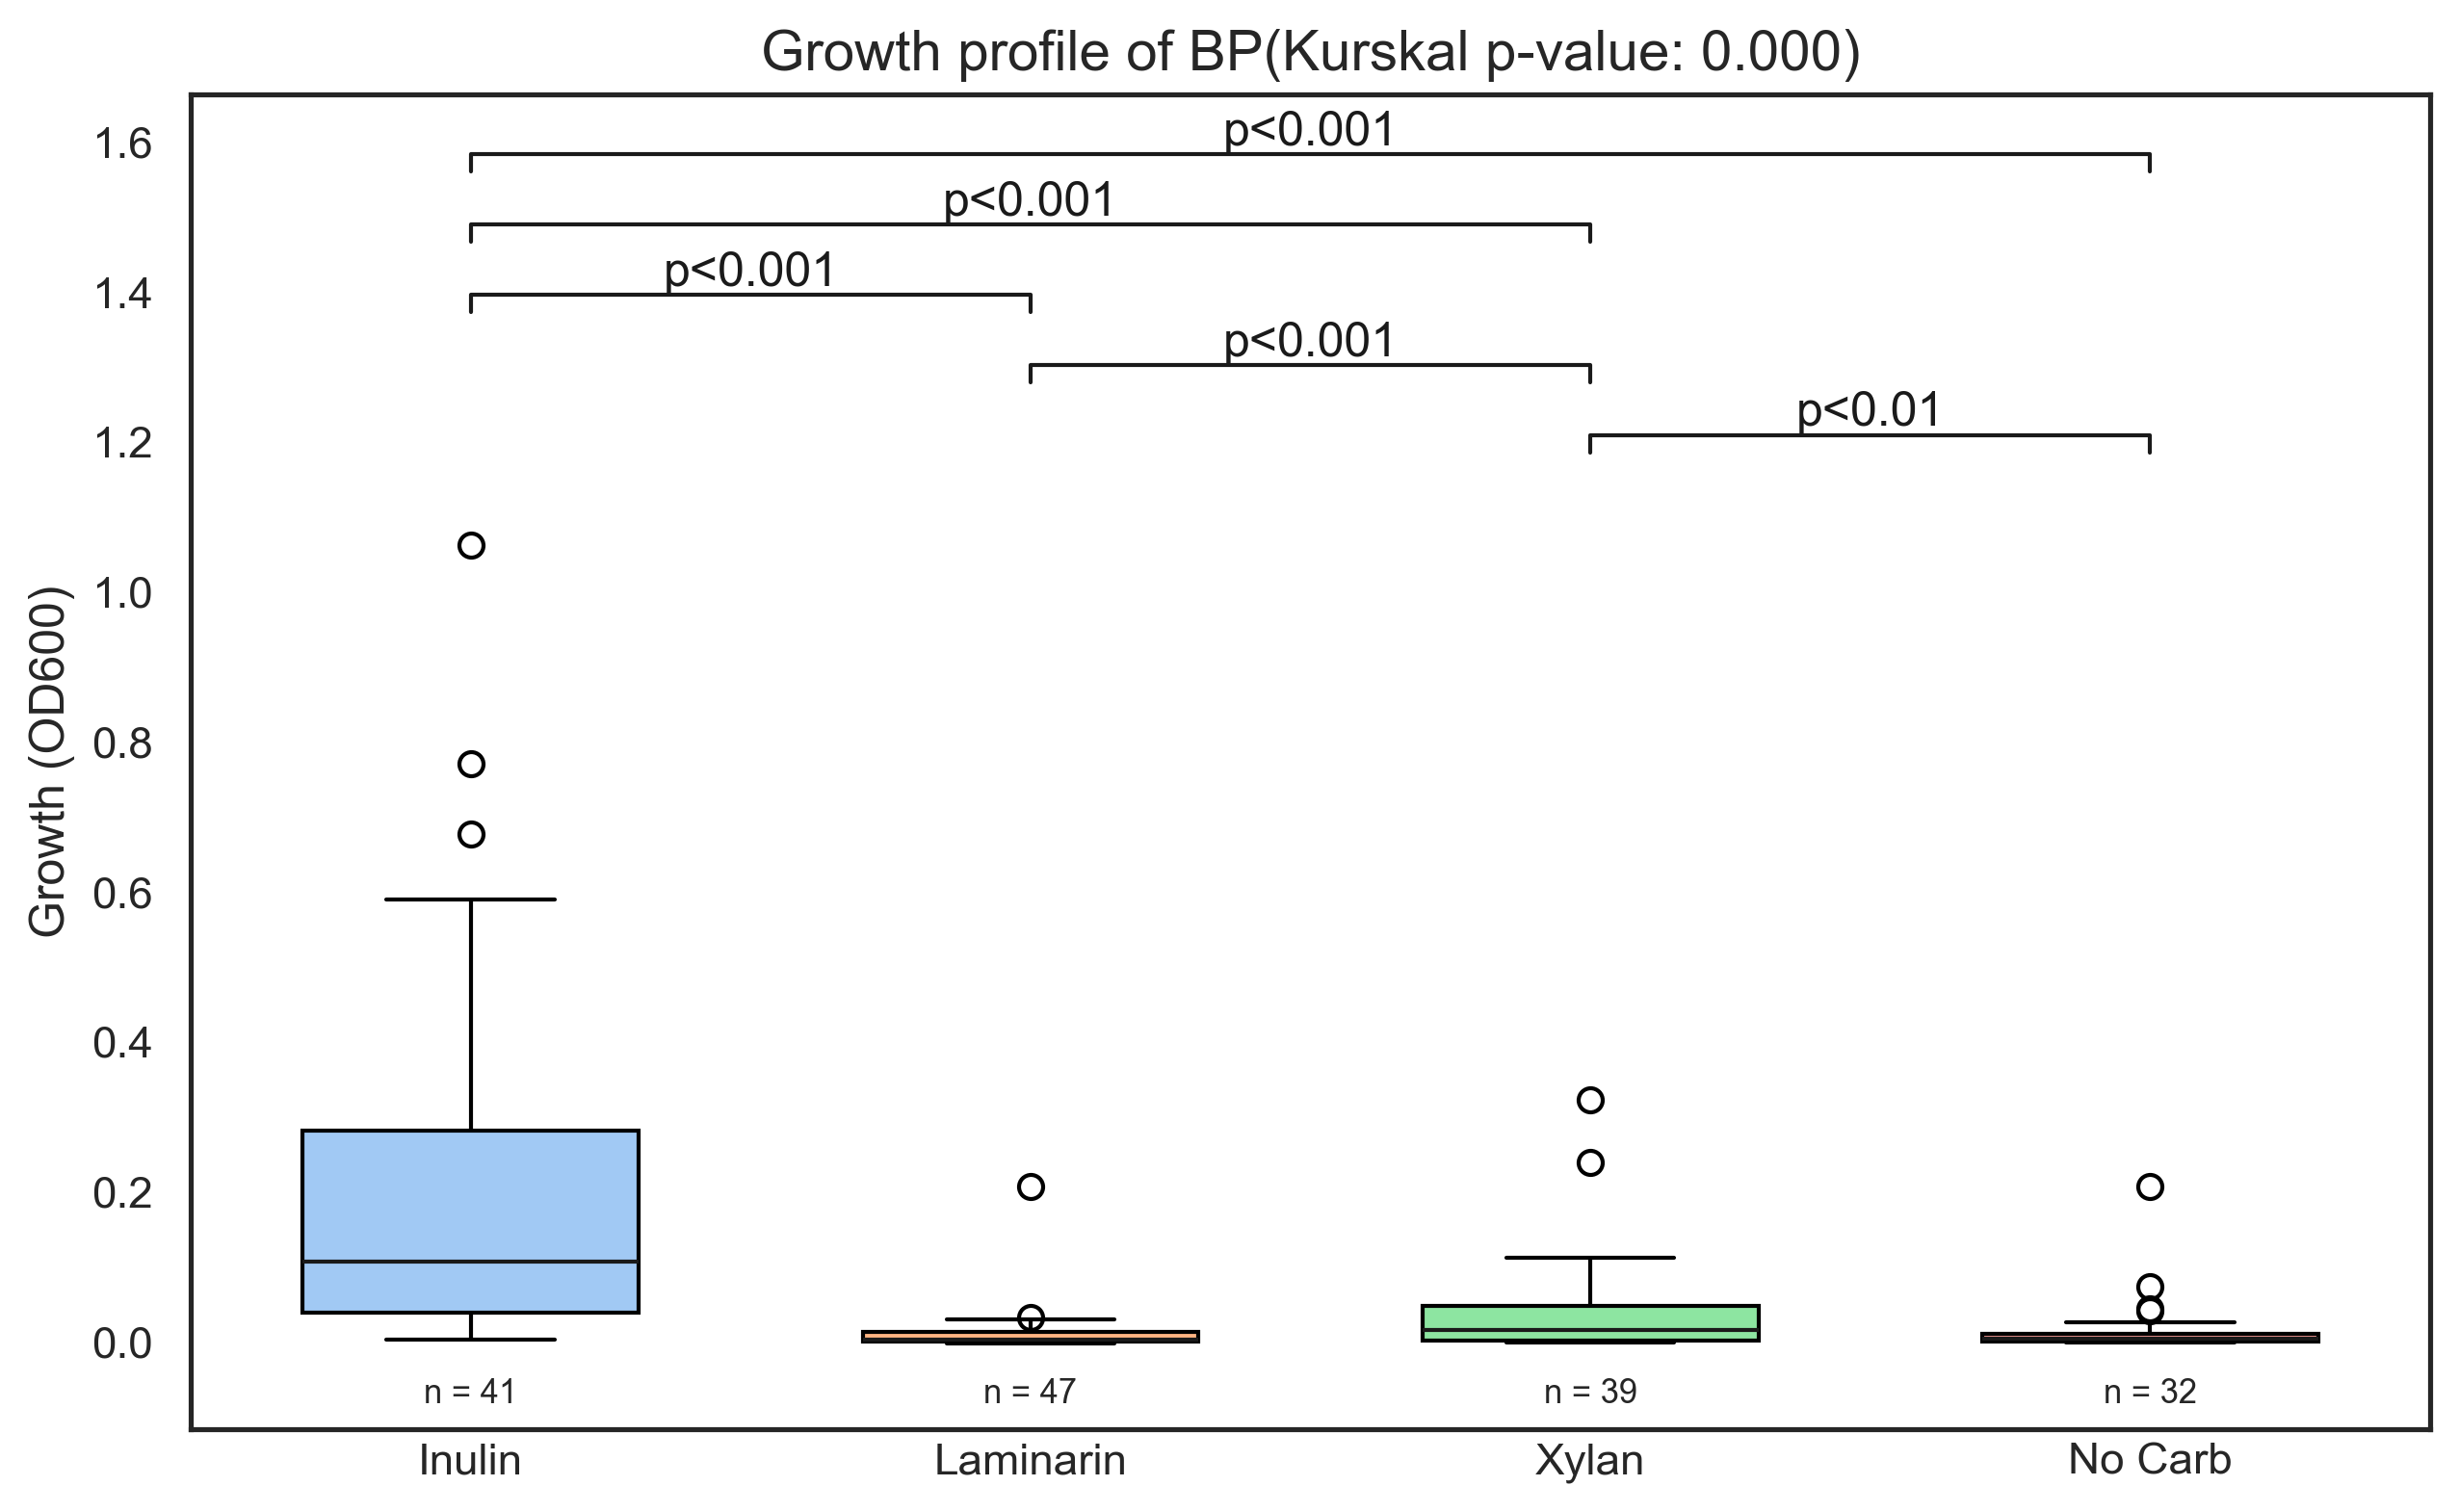

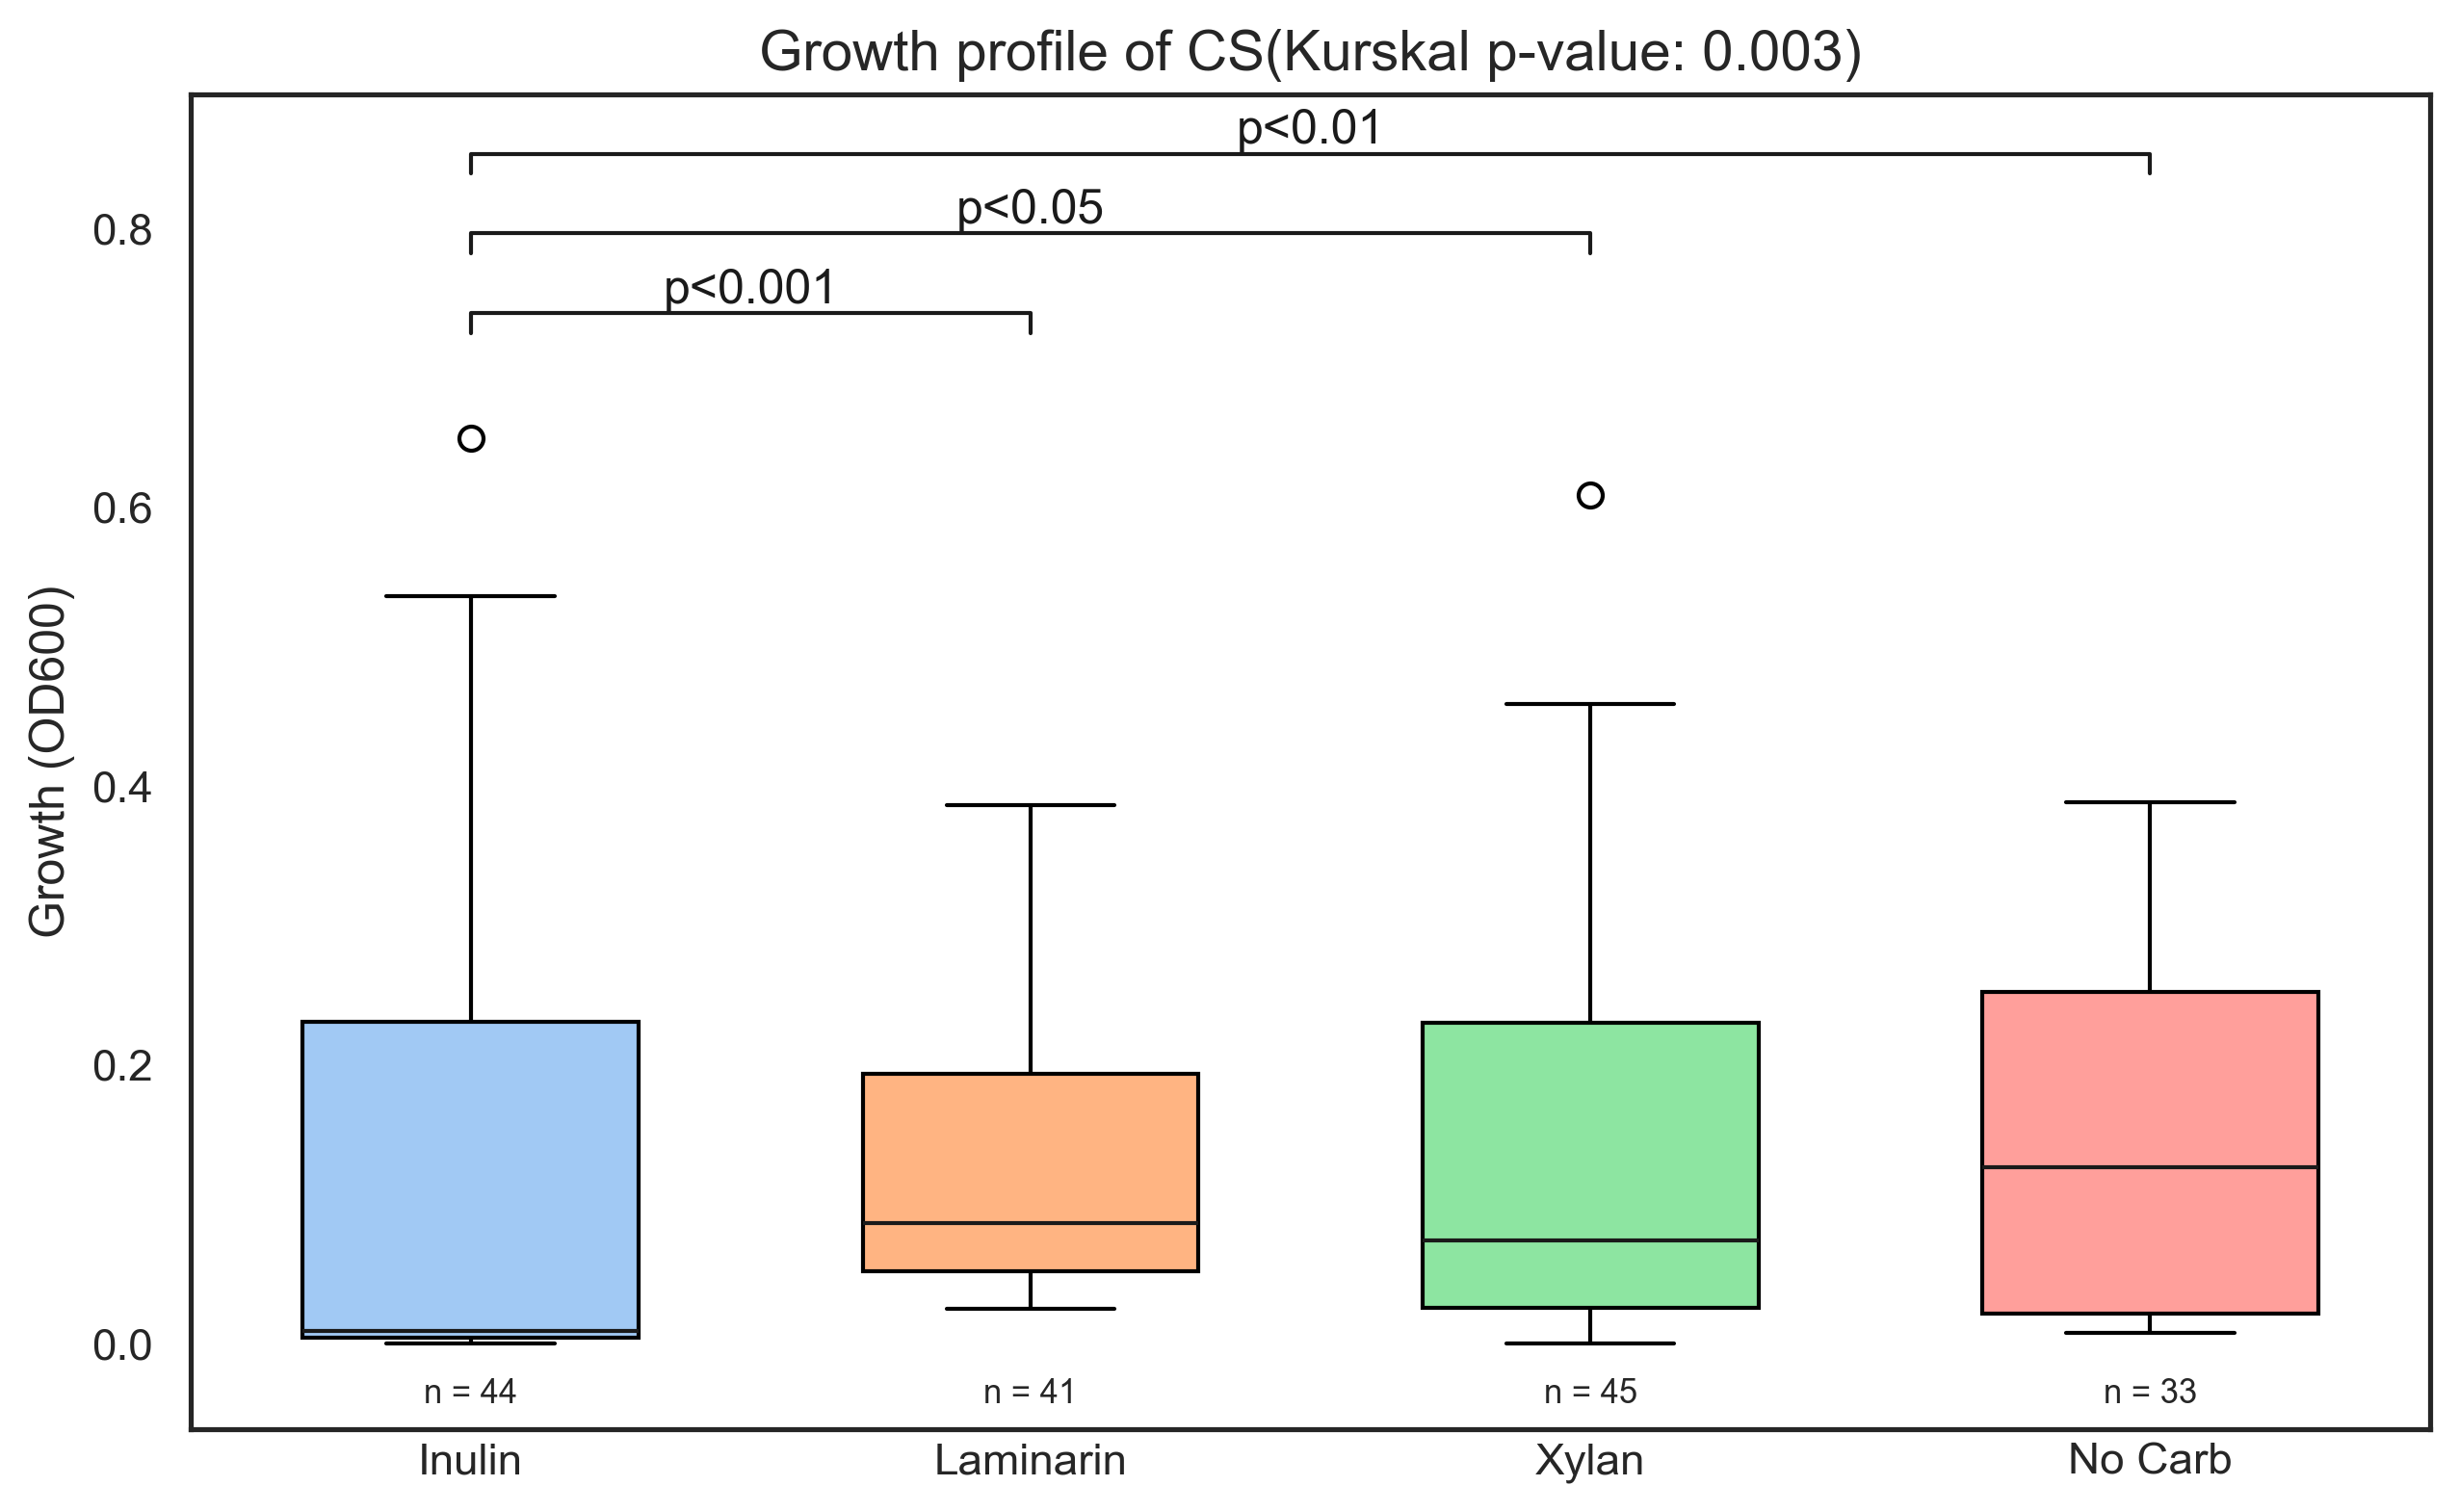

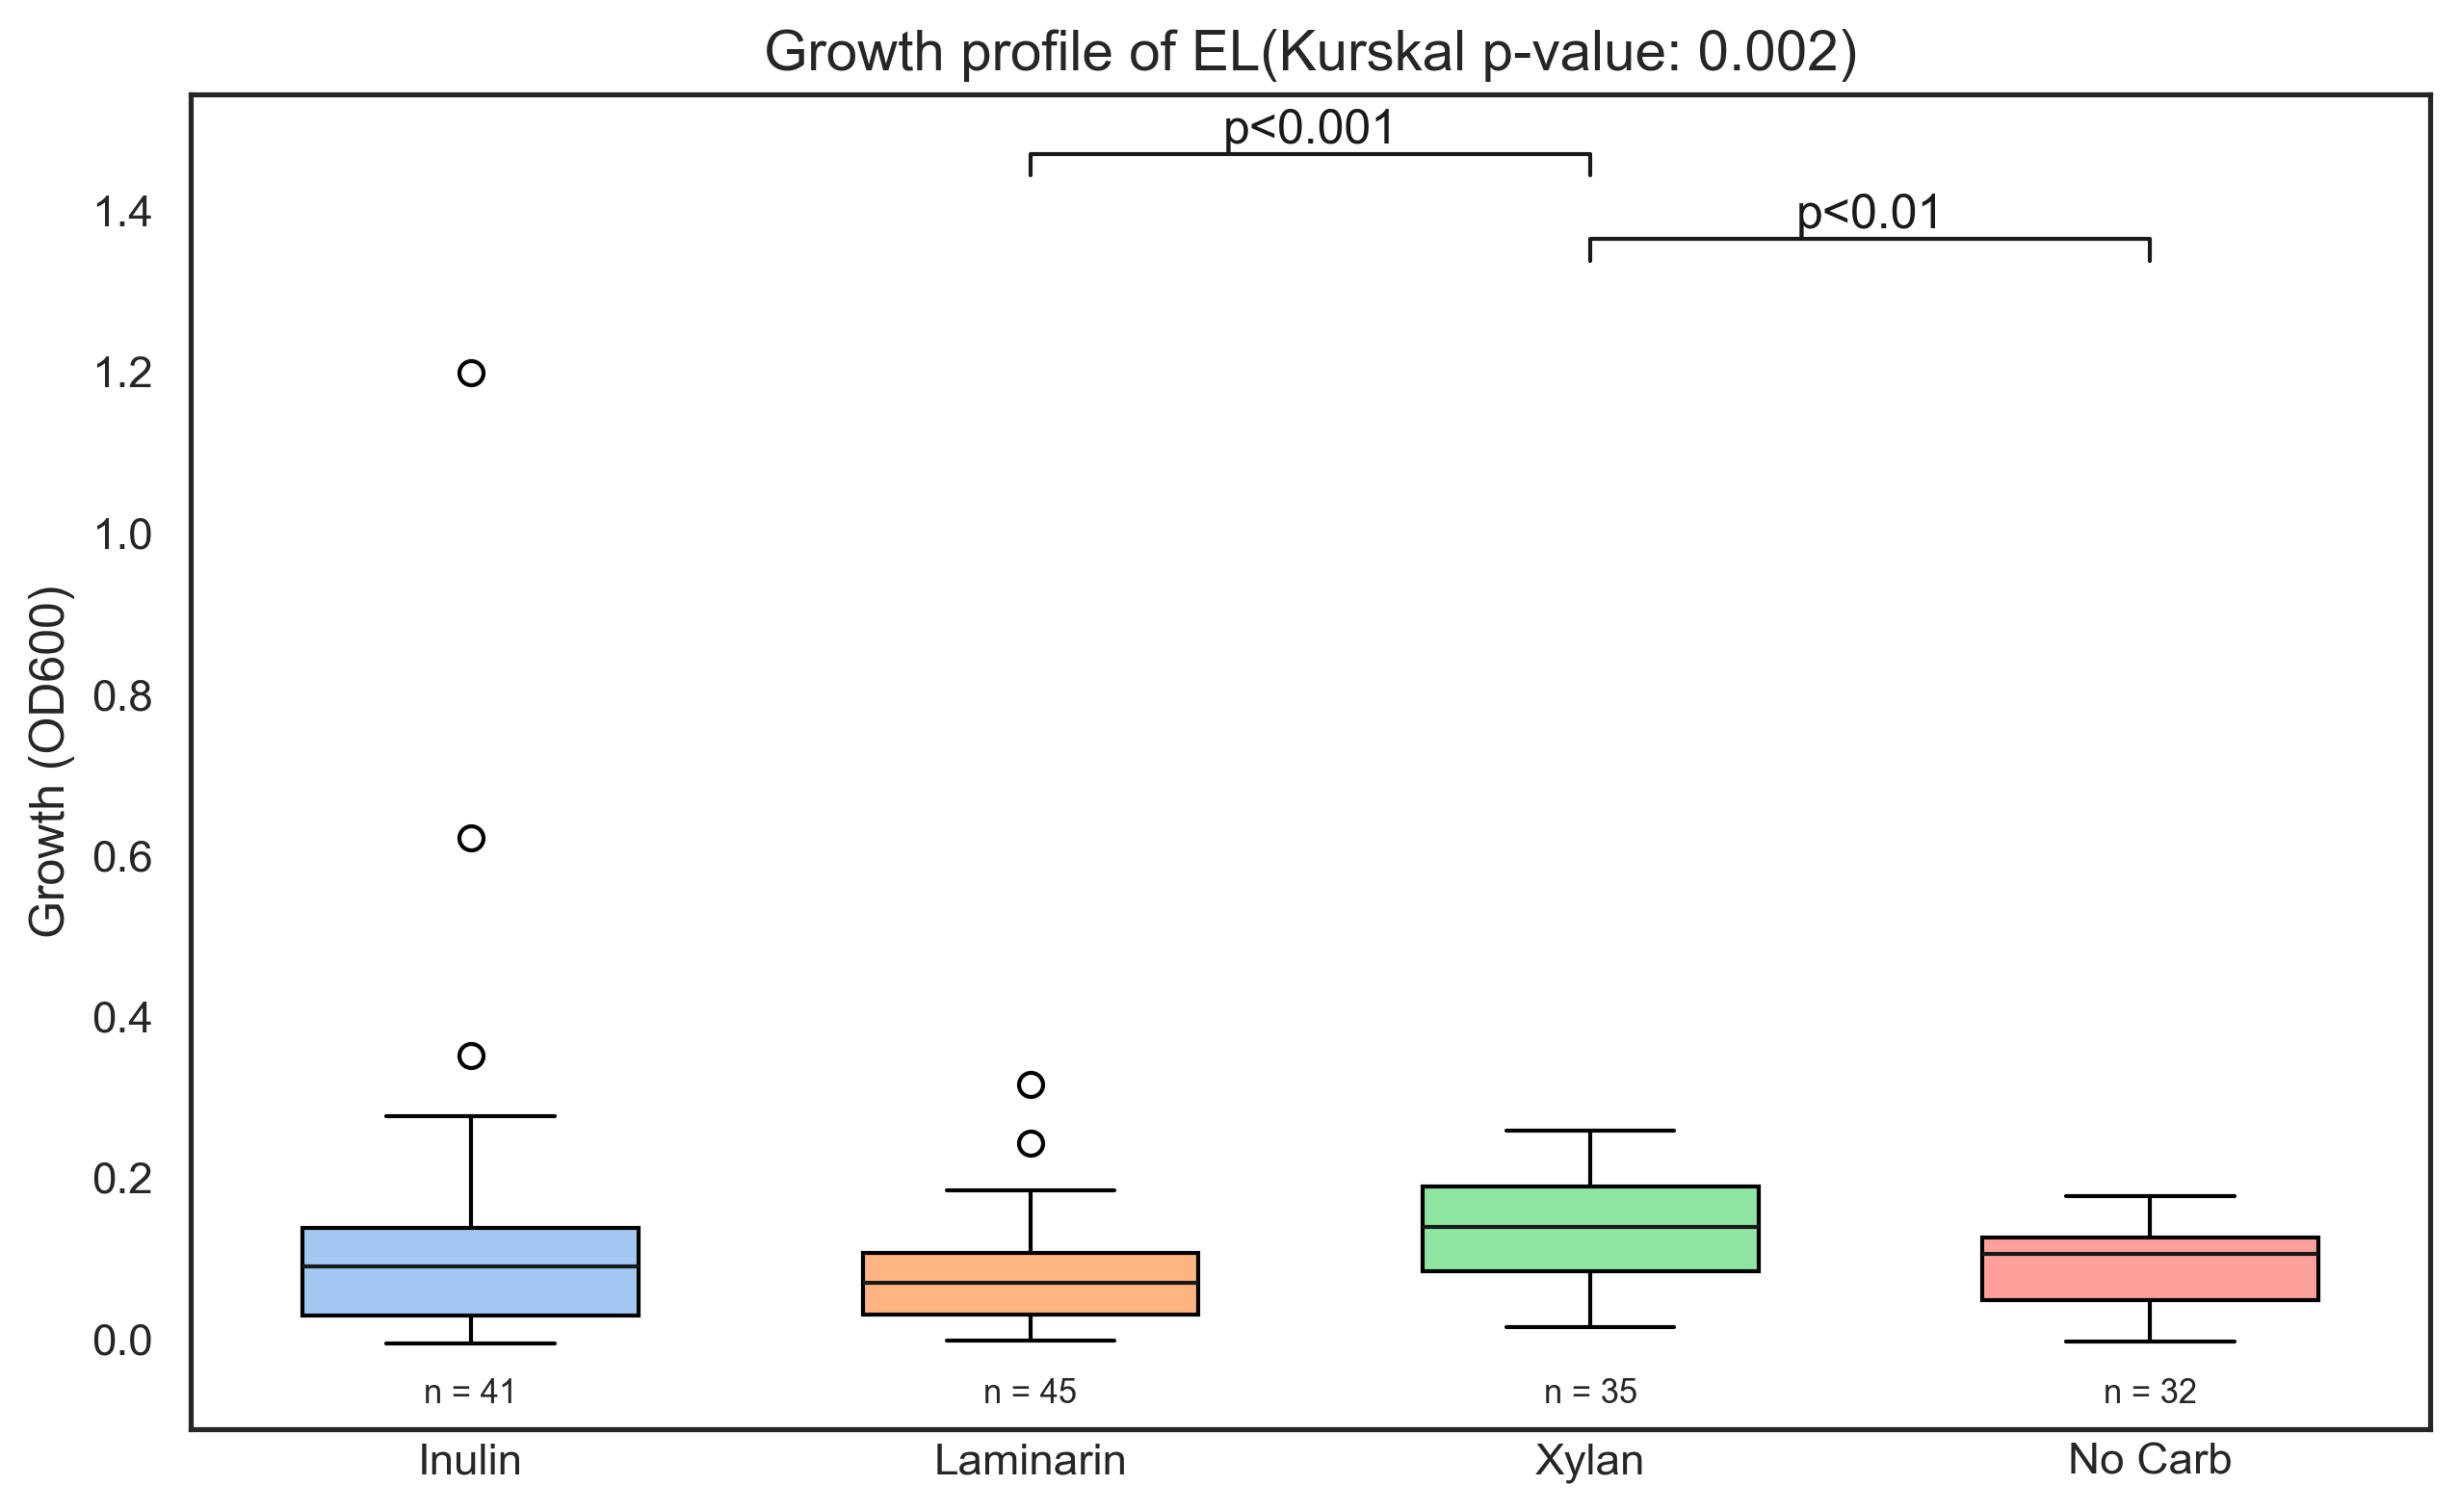

In [ ]:
def box_and_whisker(data, title, ylabel, xticklabels):
    """
    Create a box-and-whisker plot with significance bars.
    """
    fig, ax = plt.subplots(figsize=(10, 6), dpi = 300)

    bp = ax.boxplot(data, widths=0.6, patch_artist=True)
    # Graph title
    kurskal_p = stats.kruskal(*data)[1]
    ax.set_title(title + f'(Kurskal p-value: {kurskal_p:.3f})', fontsize=14)
    # Label y-axis
    ax.set_ylabel(ylabel)
    # Label x-axis ticks
    ax.set_xticklabels(xticklabels)
    # Hide x-axis major ticks
    ax.tick_params(axis='x', which='major', length=0)
    # Show x-axis minor ticks
    xticks = [0.5] + [x + 0.5 for x in ax.get_xticks()]
    ax.set_xticks(xticks, minor=True)
    # Clean up the appearance
    ax.tick_params(axis='x', which='minor', length=3, width=1)

    # Change the colour of the boxes to Seaborn's 'pastel' palette
    colors = sns.color_palette('pastel')
    for patch, color in zip(bp['boxes'], colors):
        patch.set_facecolor(color)

    # Colour of the median lines
    plt.setp(bp['medians'], color='k')

    # Check for statistical significance
    significant_combinations = []
    # Check from the outside pairs of boxes inwards
    ls = list(range(1, len(data) + 1))
    combinations = [(ls[x], ls[x + y]) for y in reversed(ls) for x in range((len(ls) - y))]
    for c in combinations:
        data1 = data[c[0] - 1]
        data2 = data[c[1] - 1]
        # Significance
        U, p = stats.mannwhitneyu(data1, data2, alternative='two-sided')
        if p < 0.05:
            significant_combinations.append([c, p])

    # Get info about y-axis
    bottom, top = ax.get_ylim()
    yrange = top - bottom

    # Significance bars
    for i, significant_combination in enumerate(significant_combinations):
        # Columns corresponding to the datasets of interest
        x1 = significant_combination[0][0]
        x2 = significant_combination[0][1]
        # What level is this bar among the bars above the plot?
        level = len(significant_combinations) - i
        # Plot the bar
        bar_height = (yrange * 0.08 * level) + top
        bar_tips = bar_height - (yrange * 0.02)
        plt.plot(
            [x1, x1, x2, x2],
            [bar_tips, bar_height, bar_height, bar_tips], lw=1, c='k')
        # Significance level
        p = significant_combination[1]
        if p < 0.001:
            sig_symbol = 'p<0.001'
        elif p < 0.01:
            sig_symbol = 'p<0.01'
        elif p < 0.05:
            sig_symbol = 'p<0.05'
        text_height = bar_height + (yrange * 0.01)
        plt.text((x1 + x2) * 0.5, text_height, sig_symbol, ha='center', c='k')

    # Adjust y-axis
    bottom, top = ax.get_ylim()
    yrange = top - bottom
    ax.set_ylim(bottom - 0.02 * yrange, top)

    # Annotate sample size below each box
    for i, dataset in enumerate(data):
        sample_size = len(dataset)
        ax.text(i + 1, bottom, fr'n = {sample_size}', ha='center', size='x-small')

    plt.show()

species = ['PJ', 'BV', 'AC', 'DP', 'BT', 'DL', 'BH', 'BP',
          'CS', 'EL']
for sp in species:
    growth_data = load_growth_data(f'{sp}_growth_profile.csv')
    box_and_whisker([
         growth_data[growth_data['Treatments'] == 'Inulin'][sp],
         growth_data[growth_data['Treatments'] == 'Laminarin'][sp],
         growth_data[growth_data['Treatments'] == 'Xylan'][sp],
         growth_data[growth_data['Treatments'] == 'No Carb'][sp],
        ],
        ylabel='Growth (OD600)',
        xticklabels=['Inulin', 'Laminarin', 'Xylan', 'No Carb'],
        title=f'Growth profile of {sp}',

        # xticklabels=[sp]
    )
    